#### Time Series Analysis

So, in the last notebook, we worked on building a forecasting model using Facebook's `prophet` package and plotted the results. 

We were able to achive a mean absolute error of roughly `52.3` and were not able to squeeze better results out of the model by changing the `changepoint_prior_scale` parameter within the model.

However, with that, we aren't really sure that we have the best results that we could achive. So we are going to try our hand at time series analysis with the `statsmodels` package.

Then, we are going to reframe this time series problem into a supervised learning problem and evaluate model performance once again. 

At the end we will determine the best course of action based on model performance. We will be able to select a model, apply it, and save it for future applications. Also, we will visualize the projections once again. 

---

#### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from sklearn.metrics import mean_absolute_error

from itertools import product

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

---

#### Load Data

In [2]:
df = pd.read_pickle("./data/Rat_Sightings.pkl")
df.head()

Created Date                 Location Type postalCode  \
0  08/02/2017 12:00:00 AM  3+ Family Mixed Use Building      10001   
1  09/08/2016 12:00:00 AM           Commercial Building      10001   
2  01/12/2016 12:00:00 AM       3+ Family Apt. Building      10001   
3  07/14/2017 12:00:00 AM             Construction Site      10001   
4  06/15/2017 12:00:00 AM                    Vacant Lot      10001   

                                  Location    Borough  \
0   (40.7456163166638, -73.98757087477563)  Manhattan   
1  (40.74864397036016, -73.98954087053794)  Manhattan   
2  (40.74925101726878, -74.00199584240312)  Manhattan   
3  (40.745421892217756, -73.9929157080262)  Manhattan   
4  (40.74518584464681, -73.99293016871866)  Manhattan   

                                              poly_x  \
0  [-74.00827017711134, -74.00762507843844, -74.0...   
1  [-74.00827017711134, -74.00762507843844, -74.0...   
2  [-74.00827017711134, -74.00762507843844, -74.0...   
3  [-74.00827017711134, -74.00762507843844, -74.0...   
4  [-74.00827017711134, -74.00762507843844, -74.0...   

                                              poly_y  \
0  [40.752587143684494, 40.75427918134466, 40.756...   
1  [40.752587143684494, 40.75427918134466, 40.756...   
2  [40.752587143684494, 40.75427918134466, 40.756...   
3  [40.752587143684494, 40.75427918134466, 40.756...   
4  [40.752587143684494, 40.75427918134466, 40.756...   

                                                  xs  \
0  [-8238562.950607049, -8238491.138551269, -8238...   
1  [-8238562.950607049, -8238491.138551269, -8238...   
2  [-8238562.950607049, -8238491.138551269, -8238...   
3  [-8238562.950607049, -8238491.138551269, -8238...   
4  [-8238562.950607049, -8238491.138551269, -8238...   

                                                  ys  \
0  [4975916.533234529, 4976165.180545851, 4976422...   
1  [4975916.533234529, 4976165.180545851, 4976422...   
2  [4975916.533234529, 4976165.180545851, 4976422...   
3  [4975916.533234529, 4976165.180545851, 4976422...   
4  [4975916.533234529, 4976165.180545851, 4976422...   

                                         boro_poly_x  ...   \
0  [-74.01092841268033, -74.01193259911061, -74.0...  ...    
1  [-74.01092841268033, -74.01193259911061, -74.0...  ...    
2  [-74.01092841268033, -74.01193259911061, -74.0...  ...    
3  [-74.01092841268033, -74.01193259911061, -74.0...  ...    
4  [-74.01092841268033, -74.01193259911061, -74.0...  ...    

                                             boro_xs  \
0  [-8238858.864036998, -8238970.649559078, -8238...   
1  [-8238858.864036998, -8238970.649559078, -8238...   
2  [-8238858.864036998, -8238970.649559078, -8238...   
3  [-8238858.864036998, -8238970.649559078, -8238...   
4  [-8238858.864036998, -8238970.649559078, -8238...   

                                             boro_ys Neighborhood  \
0  [4965915.024392721, 4965826.398628179, 4965856...      Midtown   
1  [4965915.024392721, 4965826.398628179, 4965856...      Midtown   
2  [4965915.024392721, 4965826.398628179, 4965856...      Midtown   
3  [4965915.024392721, 4965826.398628179, 4965856...      Midtown   
4  [4965915.024392721, 4965826.398628179, 4965856...      Midtown   

                                        nhood_poly_x  \
0  [-73.9622312516561, -73.96791907791587, -73.97...   
1  [-73.9622312516561, -73.96791907791587, -73.97...   
2  [-73.9622312516561, -73.96791907791587, -73.97...   
3  [-73.9622312516561, -73.96791907791587, -73.97...   
4  [-73.9622312516561, -73.96791907791587, -73.97...   

                                        nhood_poly_y  \
0  [40.75452213042196, 40.747960560355295, 40.752...   
1  [40.75452213042196, 40.747960560355295, 40.752...   
2  [40.75452213042196, 40.747960560355295, 40.752...   
3  [40.75452213042196, 40.747960560355295, 40.752...   
4  [40.75452213042196, 40.747960560355295, 40.752...   

                                            nhood_xs  \
0  [-8233437.920868702, -8234071.086791659, -8

---

#### Generate time series data

In [3]:
df["Created Date"] = pd.to_datetime(df["Created Date"])

time_data = (df
             .assign(Count=0)
             .set_index(["Created Date"])
             .groupby("Borough")
             .resample("M")
             .Count
             .count()
             .reset_index()
             .rename(columns = {"Created Date":"Date"})
            )

time_data.head()

Borough       Date  Count
0   Bronx 2010-01-31    121
1   Bronx 2010-02-28    110
2   Bronx 2010-03-31    162
3   Bronx 2010-04-30    180
4   Bronx 2010-05-31    183

---

#### Let's visualize the time series data

In [4]:
def make_time_plot(data = time_data):
    
    # instantiate the plot/title/format
    plt.figure(figsize=(15,7))
    plt.title("Rat Sightings Per Month in NYC")
    plt.grid(True)
    
    # plot a line for each Borough
    for boro in time_data.Borough.unique():
        
        plt.plot(time_data
                 .query("Borough == '%s'"%boro)
                 .sort_values(["Date"])
                 .reset_index(drop=True)
                 .Count
                )
        
    # create legend
    plt.legend(['Bronx', 'Staten Island',
                'Brooklyn', 'Queens',
                'Manhattan'],
              
               loc="upper left"
              )
    # set tick labels
    # define func to get months every 3 months
    months = [*pd.Series(time_data.Date.unique()).astype(str)]
    def get_tick_labels(all_months=months):
        
        ticks = all_months[::3]
        
        tick_labels = []
        
        for month in all_months:
            
            if month in ticks:
                
                tick_labels.append(month)
                
            else:
                
                tick_labels.append(" ")
                
        return tick_labels
    
    # add in ticks to the plot
    plt.xticks(
        np.arange(len([*pd.Series(time_data.Date.unique()).astype(str)])),
        get_tick_labels(),
        rotation=90
    )
    
    return plt.show()
    

---

#### Let's take a look

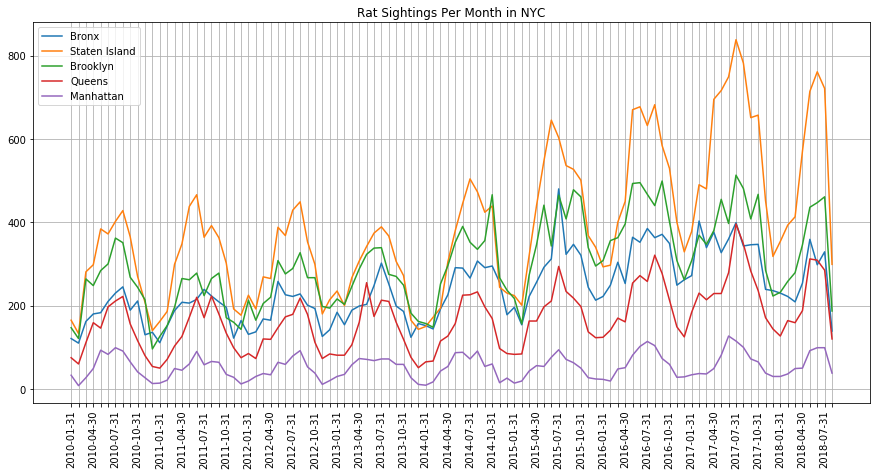

In [5]:
make_time_plot()

---

#### First approach

So what if we take the naive assumption the current months rat sightings won't be significantly different from the previous months rat sightings. 


This is generally regarded as  a 'moving average' and essentially declares that the future value fo the variable is dependent on the average of the **n** observations prior. 

This provides a smoothing like effect such to make trends within the data more detectable. we're going to use the pandas method `.rolling(window).mean()` to calculate and plot the moving average. The `window` parameter controls the smoothness of the trend essentially.The higher the value indicates the wideness of the window and correspondingly, how smooth the trend. The `window` parameter takes in the last **n** observations you'd like to determine the moving average. 

In [6]:
 def mov_avg_plot(data = time_data, window=4, plot_intervals=False, scale=1.96, plot_anomalies=False):
        
        """ data -  will be the time series data generated earlier
        in the notebook. 
            window -  will be specified to take the last 4 months
        moving avg by default.
            plot_intervals - displays the conf intervals of the mov avg
            plot_anomalies - displays anomalies within the time series
        data.
        """
        
        # plot a moving average for each Borough
        i = 0
        for boro in time_data.Borough.unique():
            
            # get data
            data = (time_data
                     .query("Borough == '%s'"%boro)
                     .sort_values(["Date"])
                     .reset_index(drop=True)
                     .Count
                    )
            data = pd.DataFrame(data)
            
            # get moving avg
            moving_avg = data.rolling(window=window).mean()

            # instantiate the plot/title/format

            plt.subplot(511+i)
            i+=1
            plt.figure(figsize=(15,7))
            plt.title("Rat Sightings Per Month in %s" %boro)
            plt.plot(moving_avg, label = "Moving Average for %s" %boro)
            
            # months
            months = [*pd.Series(time_data.Date.unique()).astype(str)]
            
            def get_tick_labels(all_months=months):
        
                ticks = all_months[::3]

                tick_labels = []

                for month in months:

                    if month in ticks:

                        tick_labels.append(month)

                    else:

                        tick_labels.append(" ")

                return tick_labels

            # add in ticks to the plot
            plt.xticks(
                np.arange(len([*pd.Series(time_data.Date.unique()).astype(str)])),
                get_tick_labels(),
                rotation=90
            )
            
            # plot conf intervals
            if plot_intervals:
                
                mae = mean_absolute_error(data[window:], moving_avg[window:])
                deviation = np.std(data[window:] - moving_avg[window:])
                lower = moving_avg - (mae+scale*deviation)
                upper = moving_avg + (mae+scale*deviation)
                plt.plot(upper, "r--", label="Upper Bound/Lower Bound")
                plt.plot(lower, "r--")
                
                if plot_anomalies:
                    
                    anomalies = pd.DataFrame(index=data.index, columns=data.columns)
                    anomalies[data<lower] = data[data<lower]
                    anomalies[data>upper] = data[data>upper]
                    plt.plot(anomalies, "ro", markersize=10)
                    
            plt.plot(data[window:], label="Actual values")
            plt.legend(loc="upper left")
            plt.show()



---

#### Plot of the Moving Averages

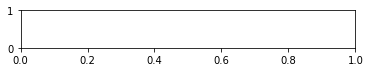

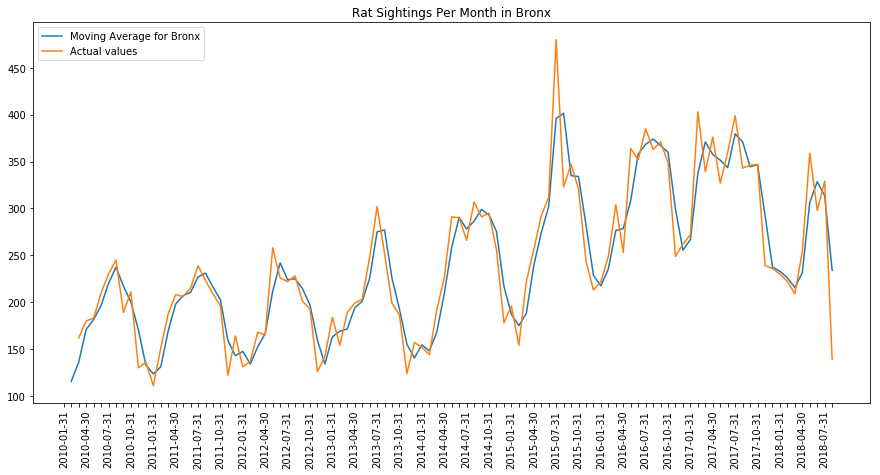

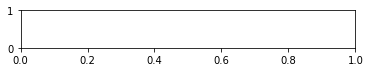

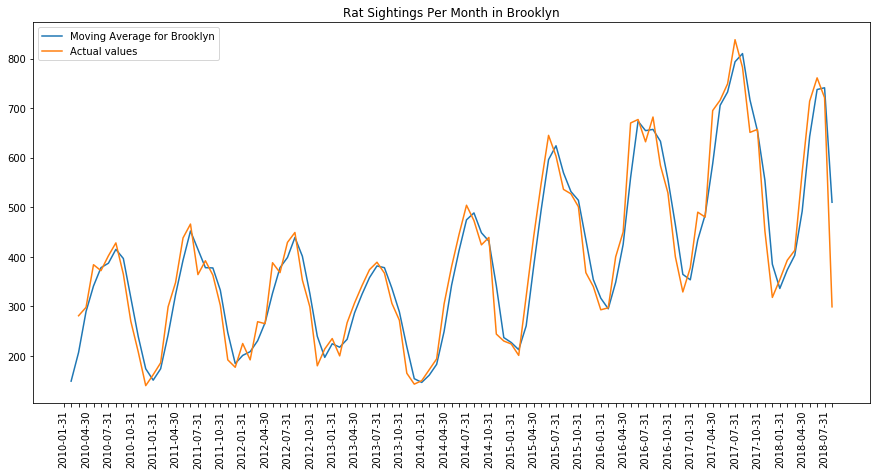

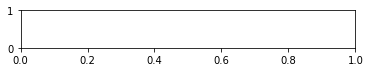

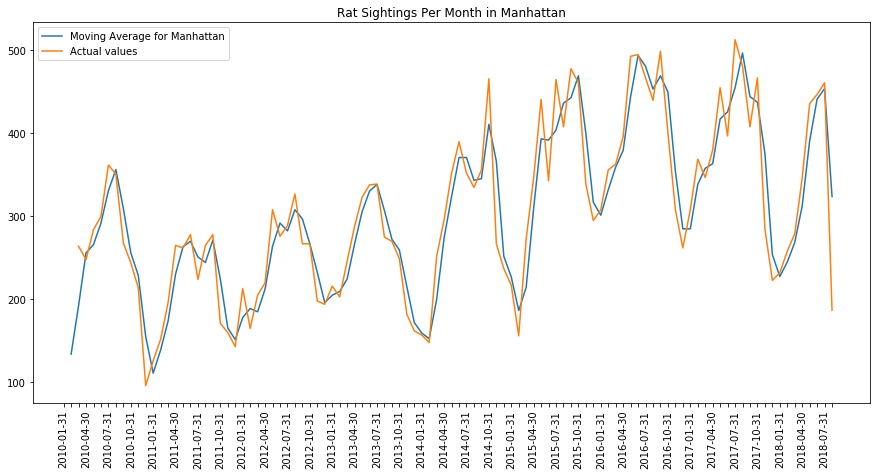

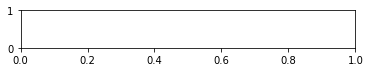

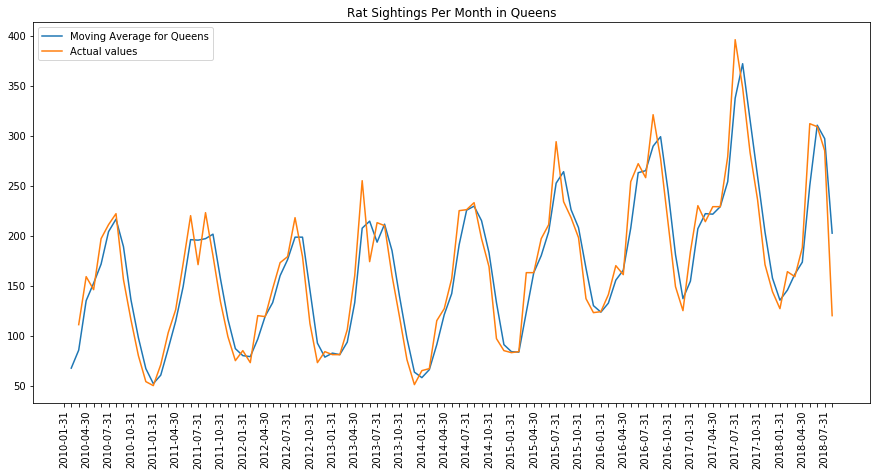

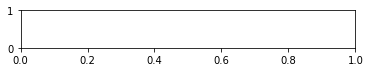

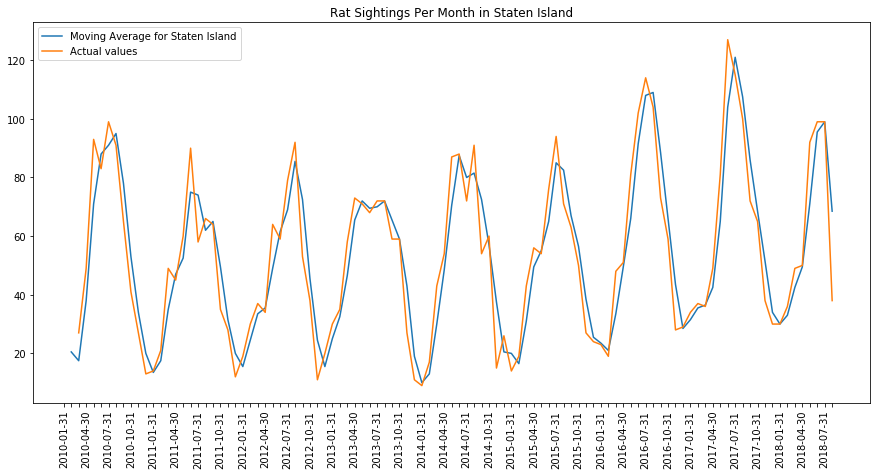

In [7]:
# window of 4 months
mov_avg_plot(window=2)

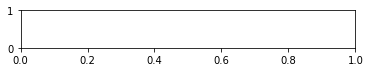

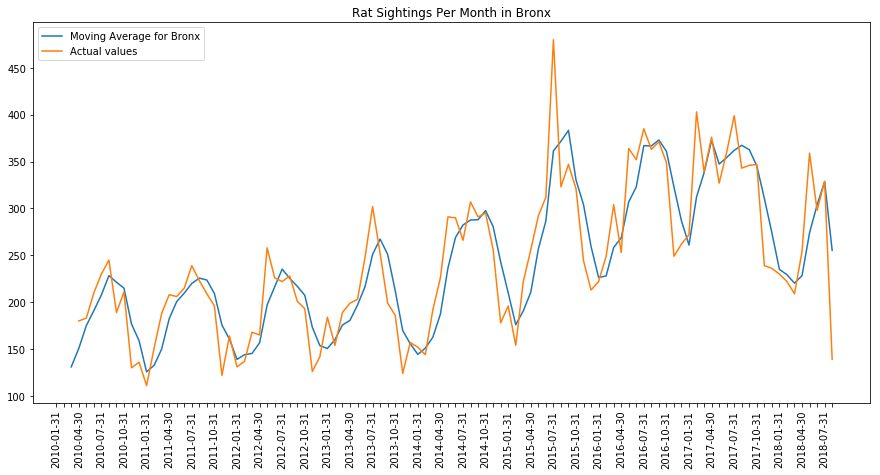

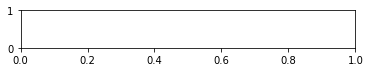

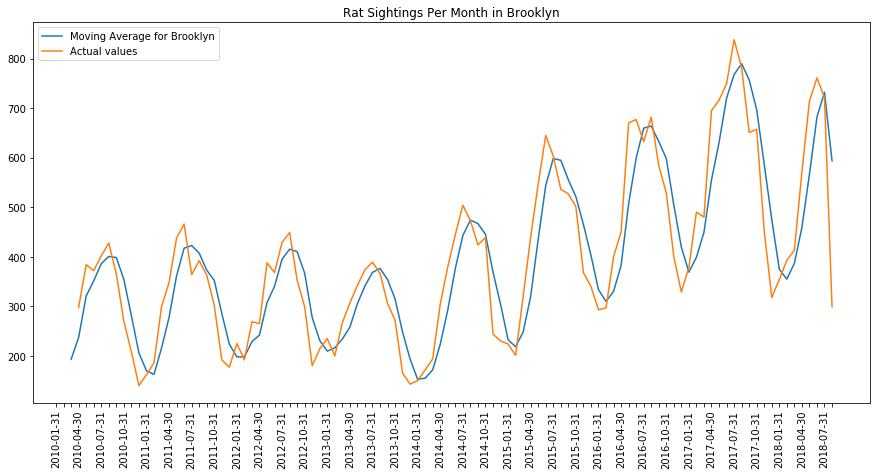

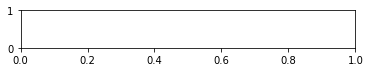

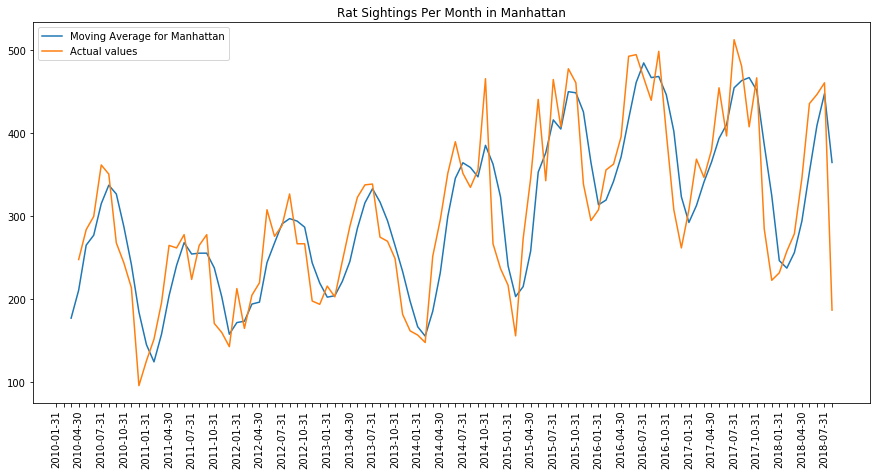

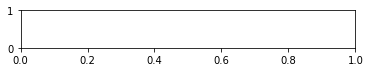

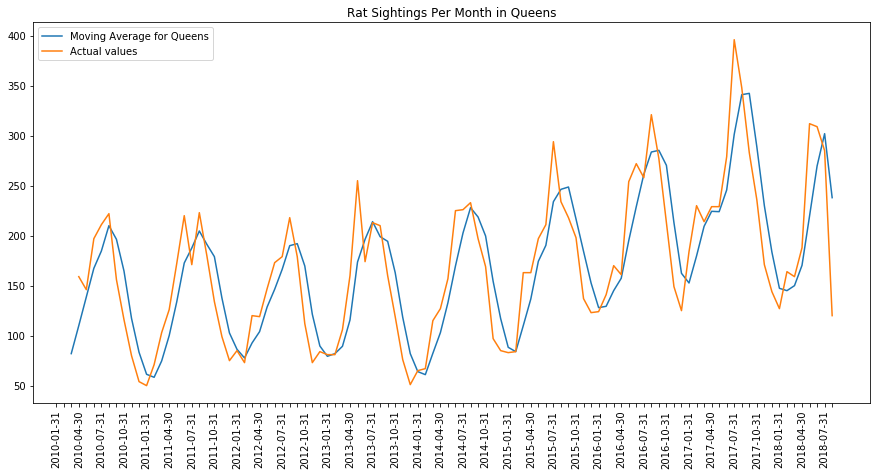

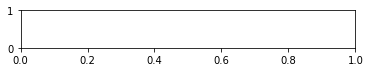

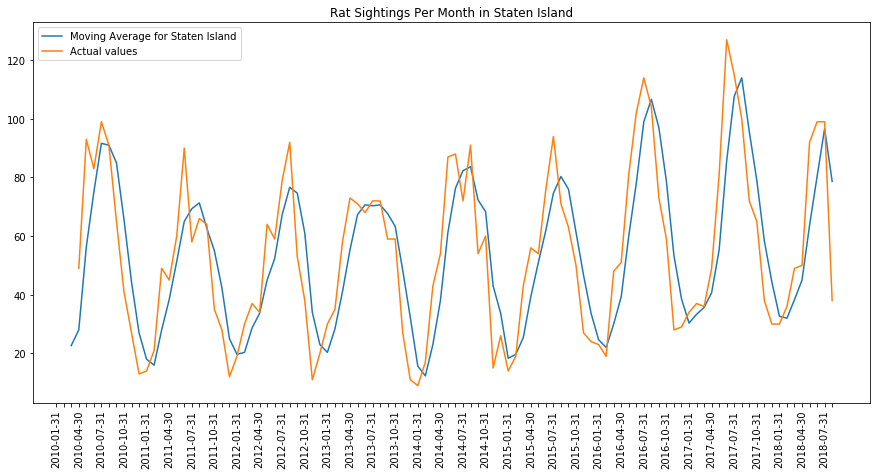

In [8]:
# window of 3 months



mov_avg_plot(window=3)

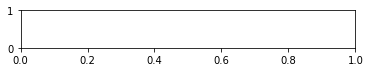

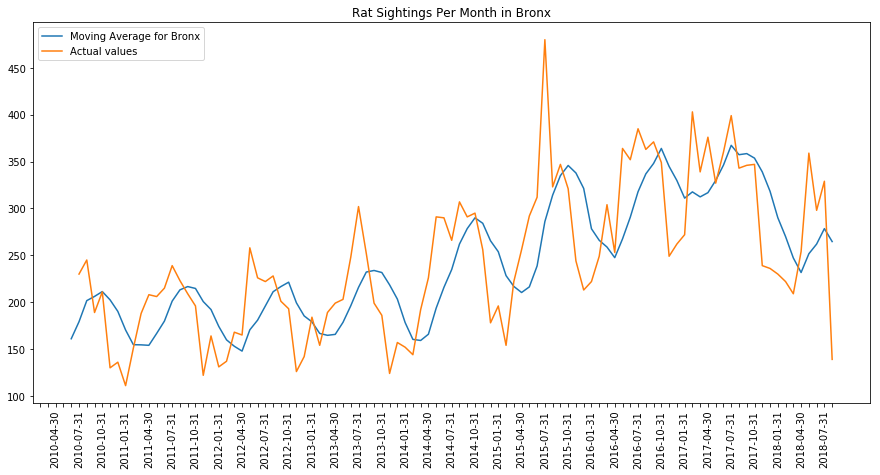

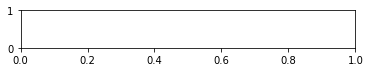

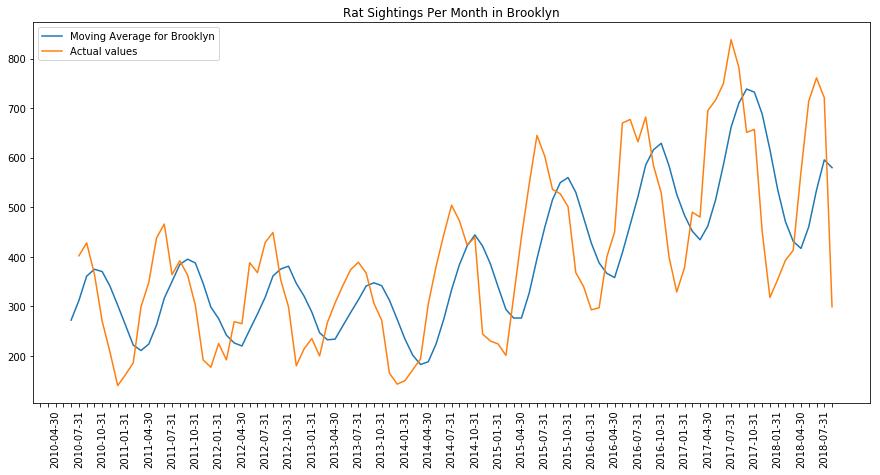

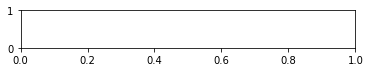

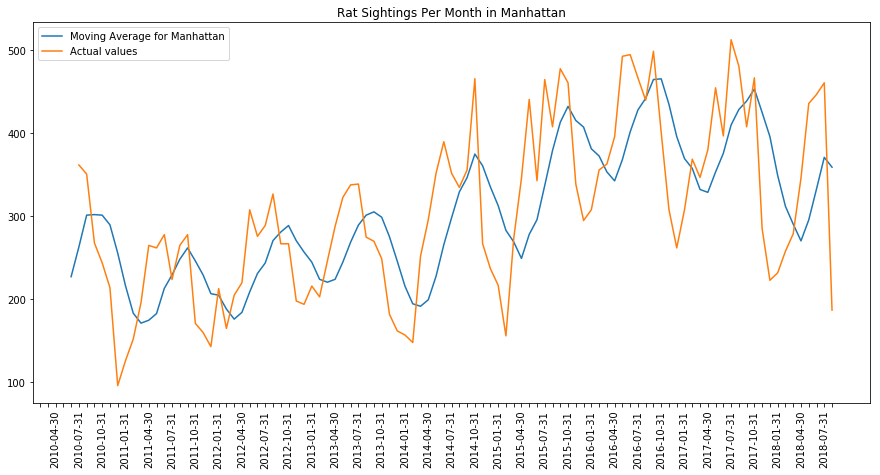

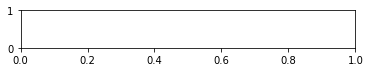

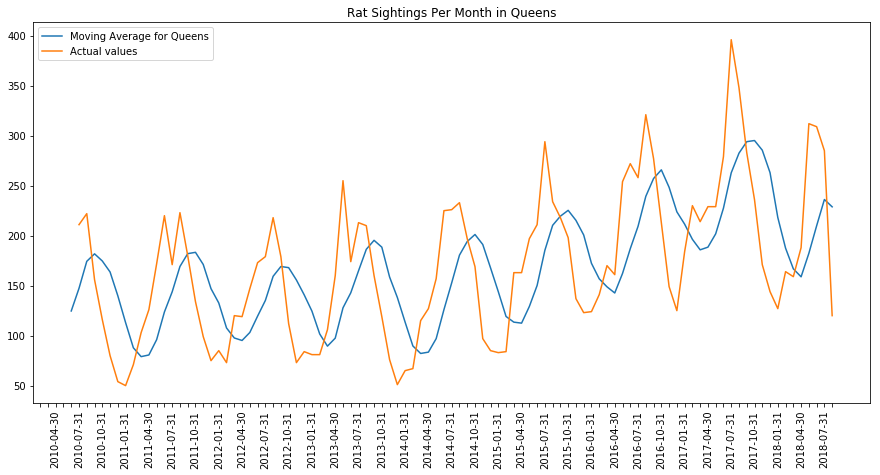

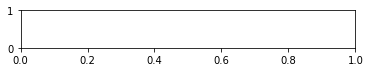

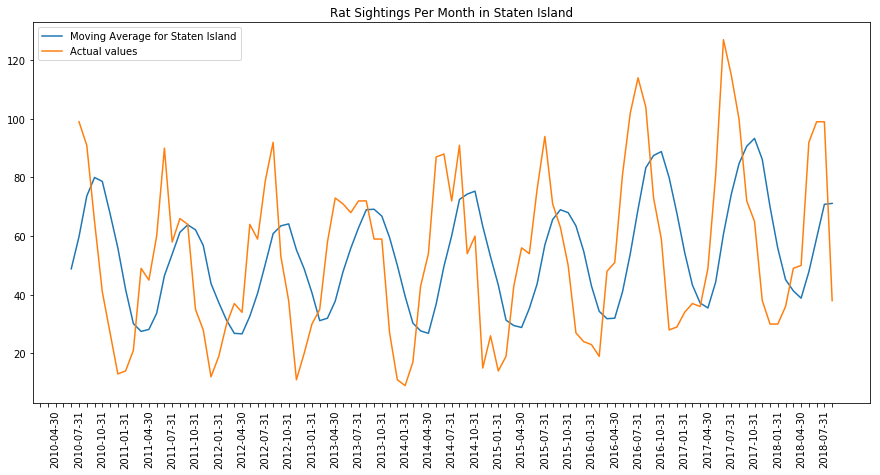

In [9]:
# window of 6 months
mov_avg_plot(window=6)

---

#### Moving Average with Confidence Intervals?

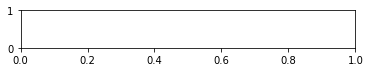

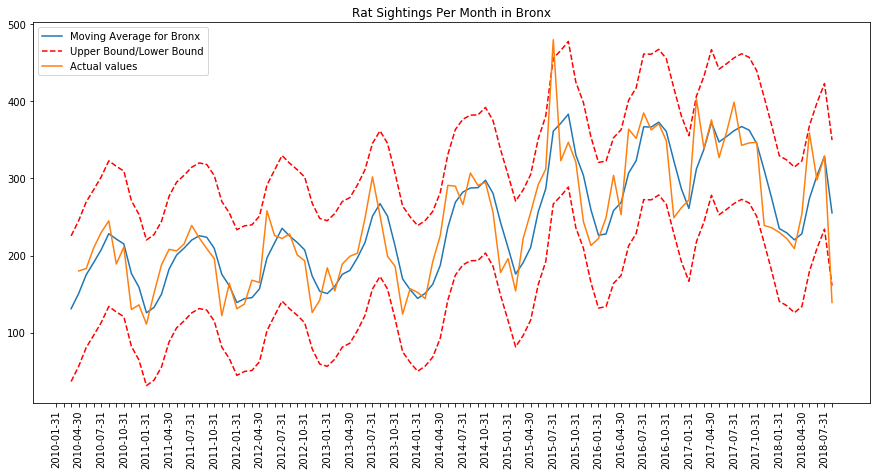

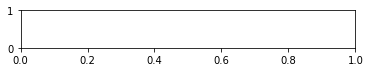

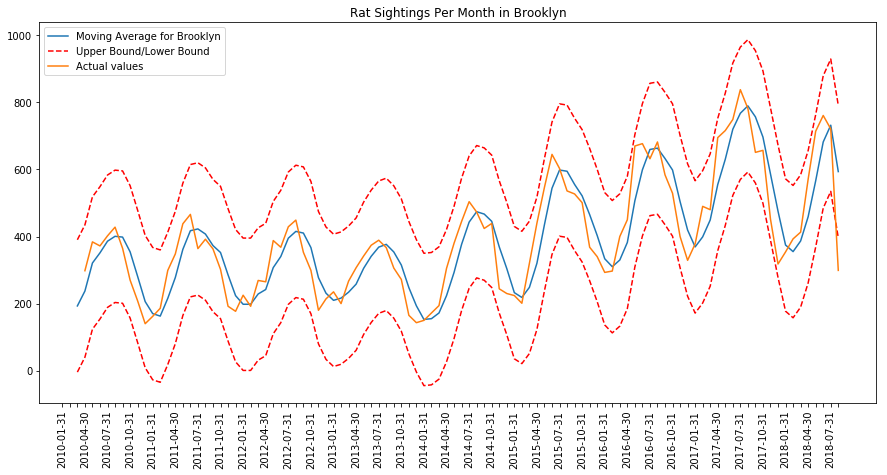

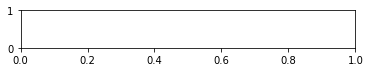

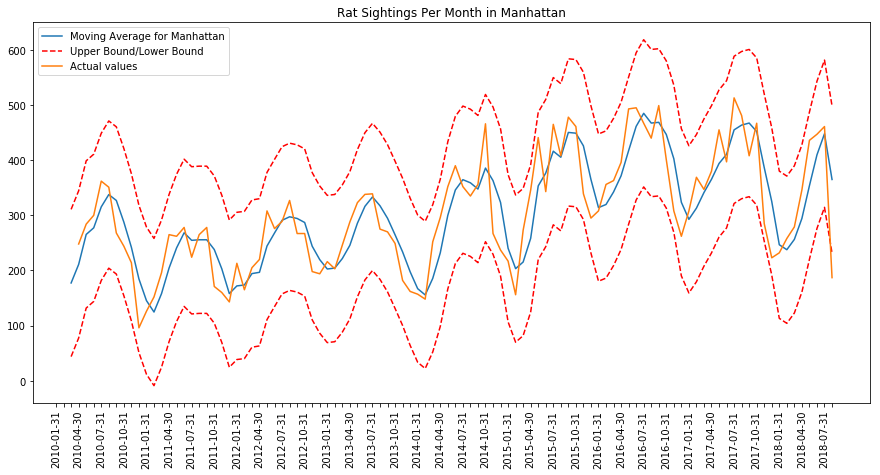

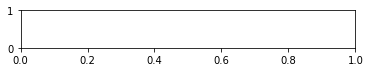

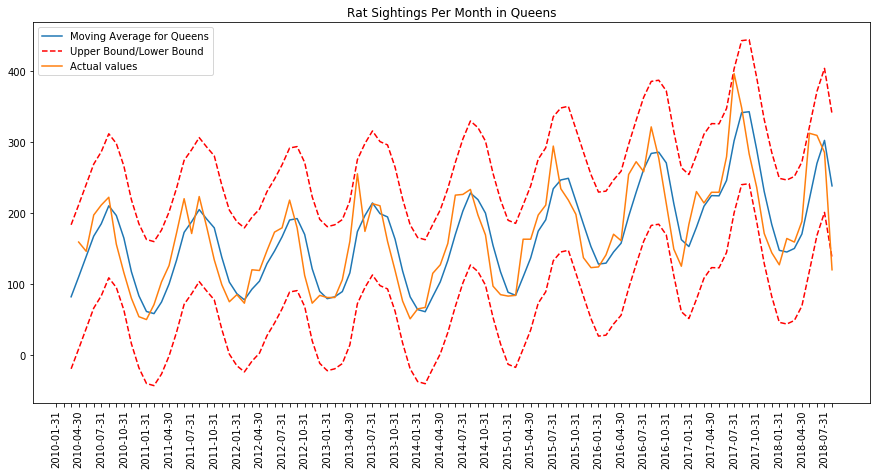

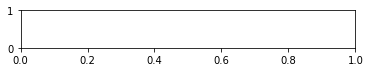

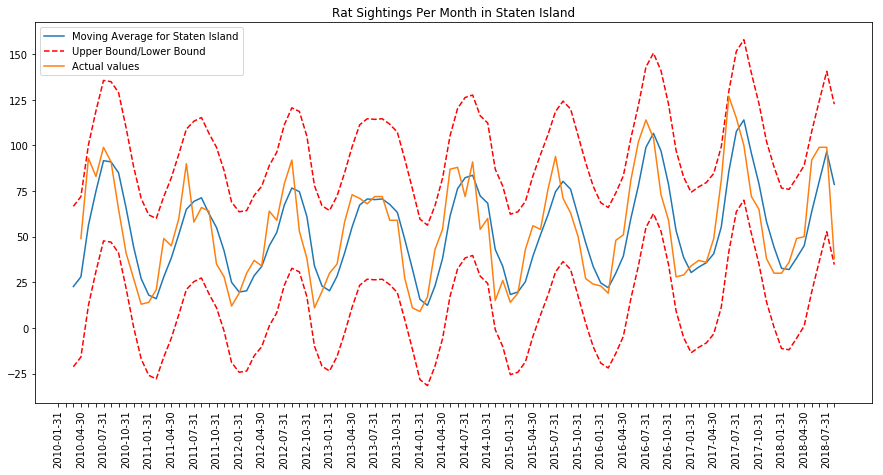

In [10]:
mov_avg_plot(window=3, plot_intervals=True)

---

#### Any anomalies?

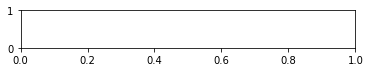

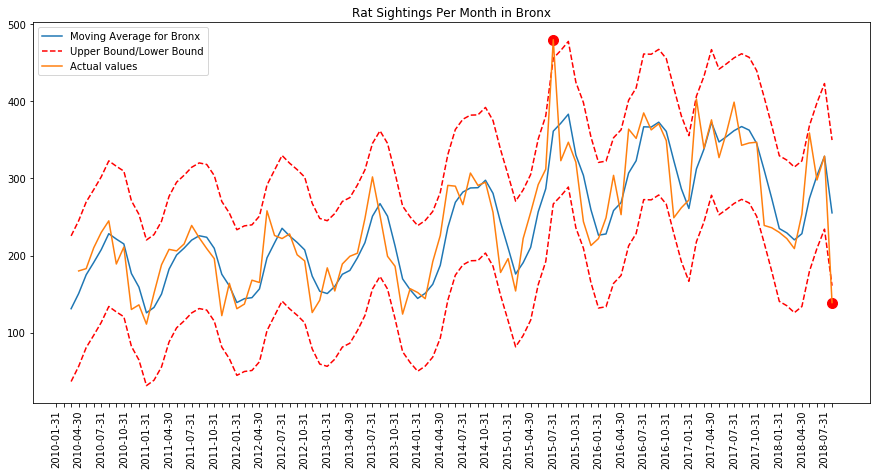

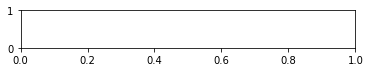

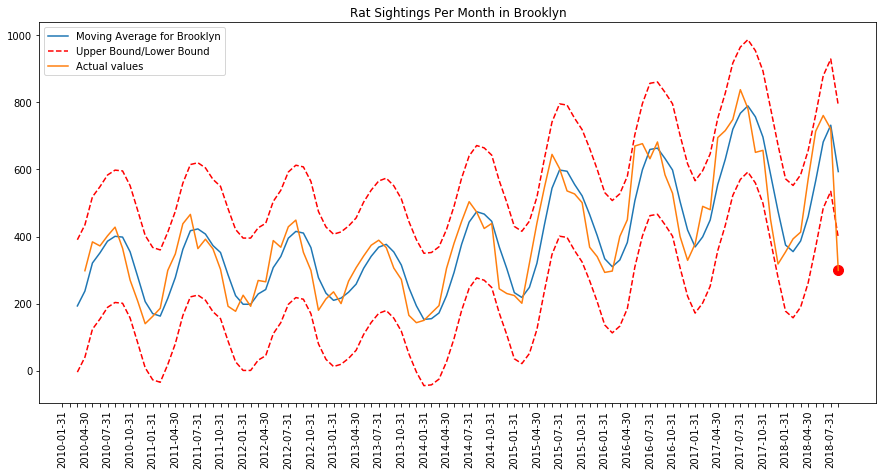

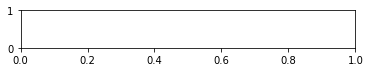

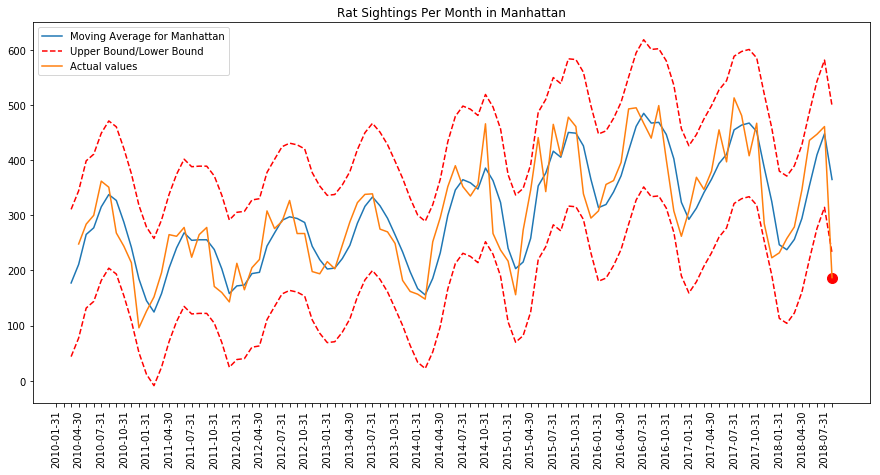

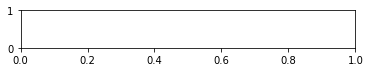

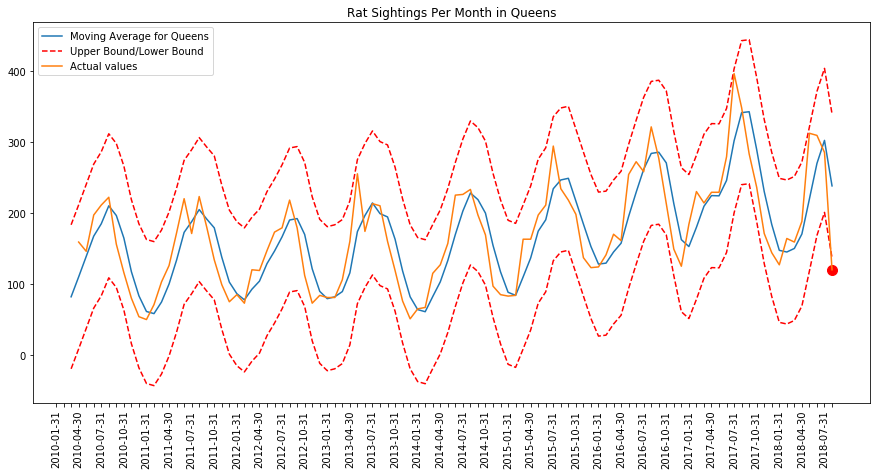

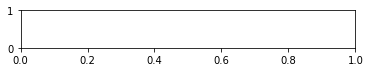

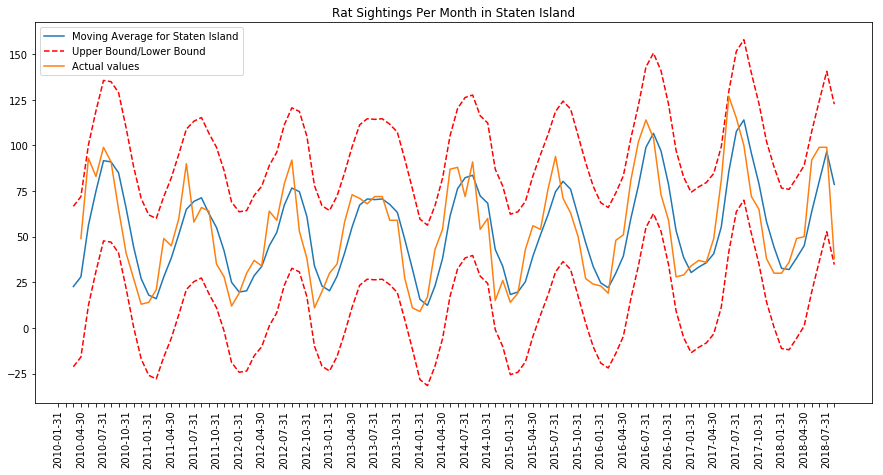

In [11]:
mov_avg_plot(window=3, plot_intervals=True, plot_anomalies=True)

So it appears that there is really only one anomaly for the Bronx series which appears to have occured Aug/Sep 2015. The rest occur at end points.

---

#### What about with 6 month smoothing?

In the previous example, there was one anomaly using 4 month smoothing, essentially to capture the seasons, what if we apply six month smoothing?

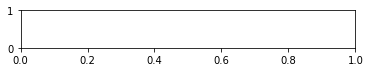

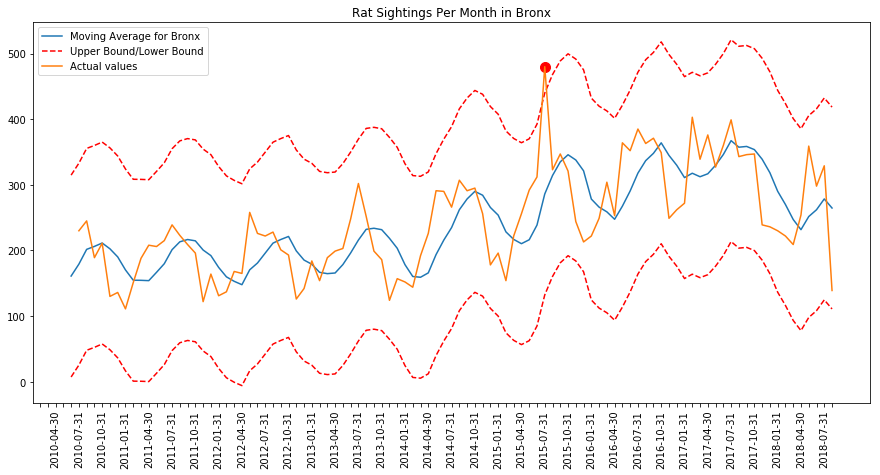

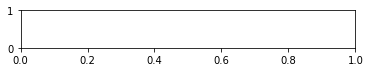

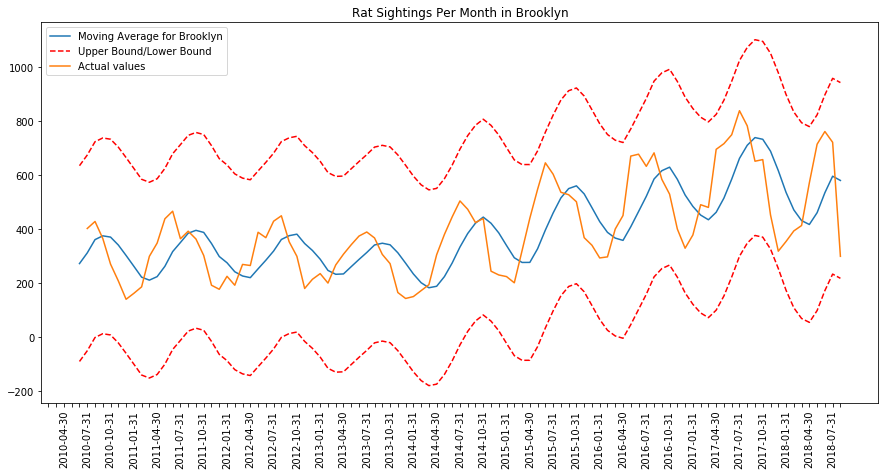

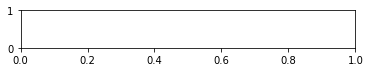

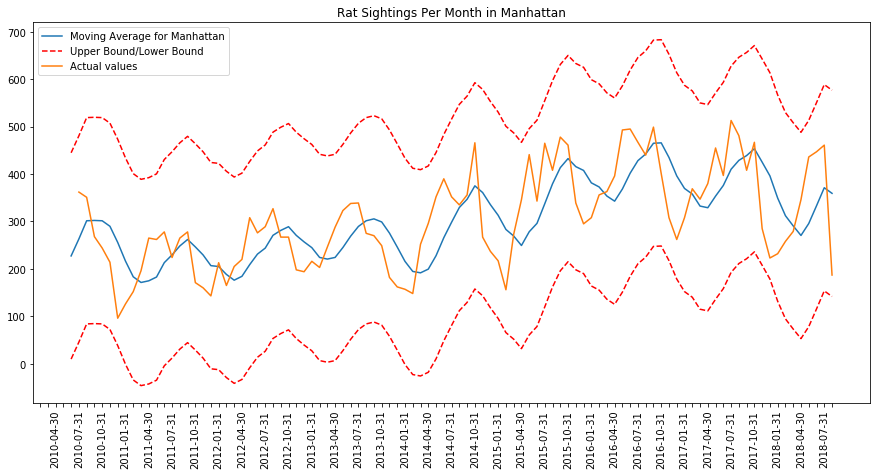

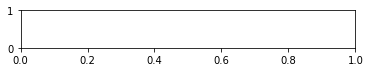

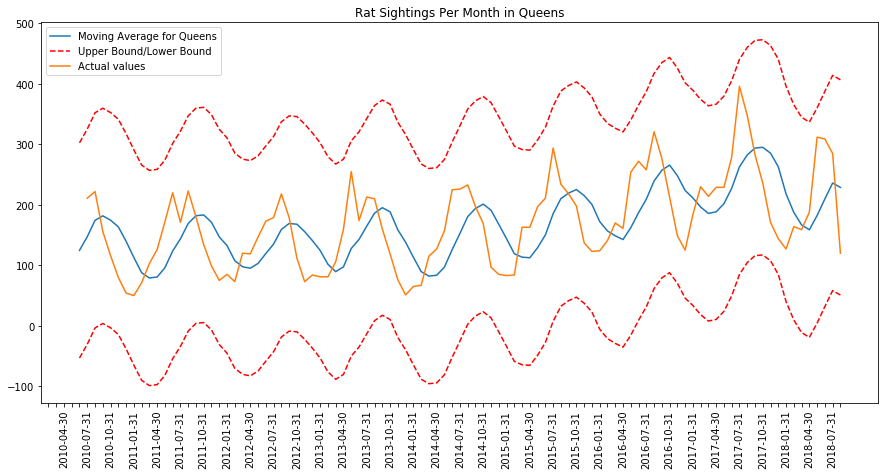

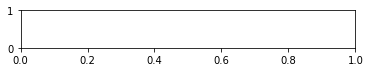

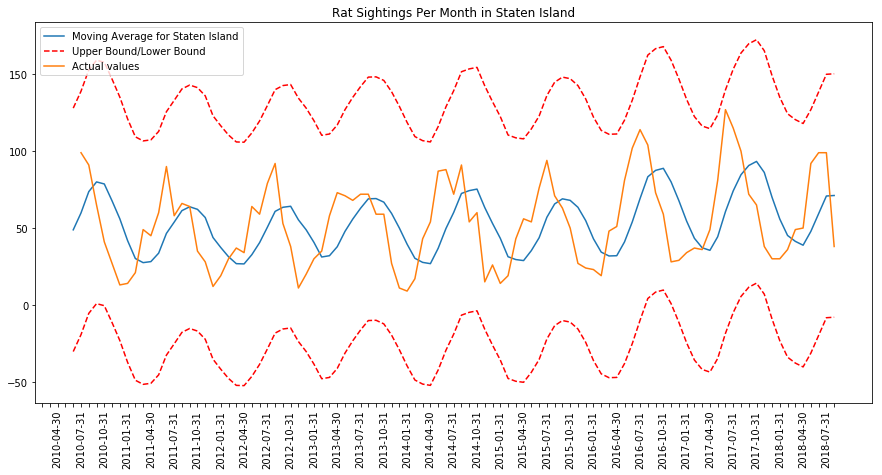

In [12]:
mov_avg_plot(window=6, plot_intervals=True, plot_anomalies=True)

The one anomaly still remains, however, all the end point anomalies vanished. 

---

#### Yearly anomalies?

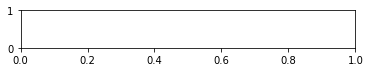

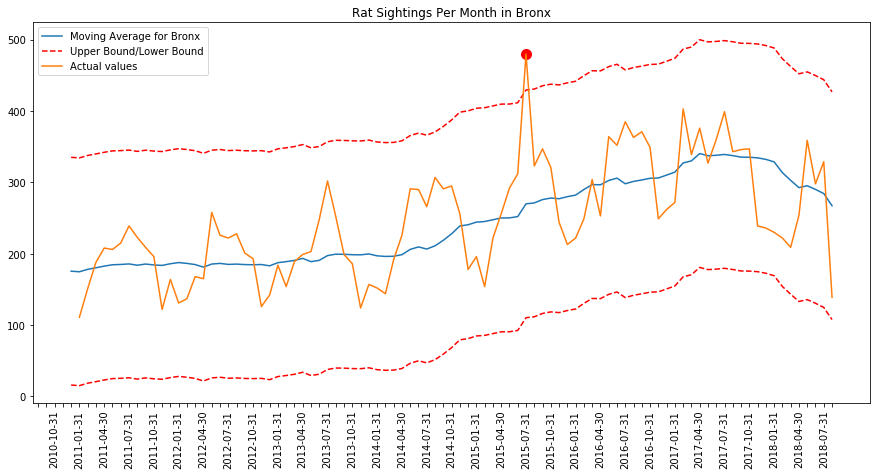

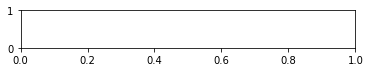

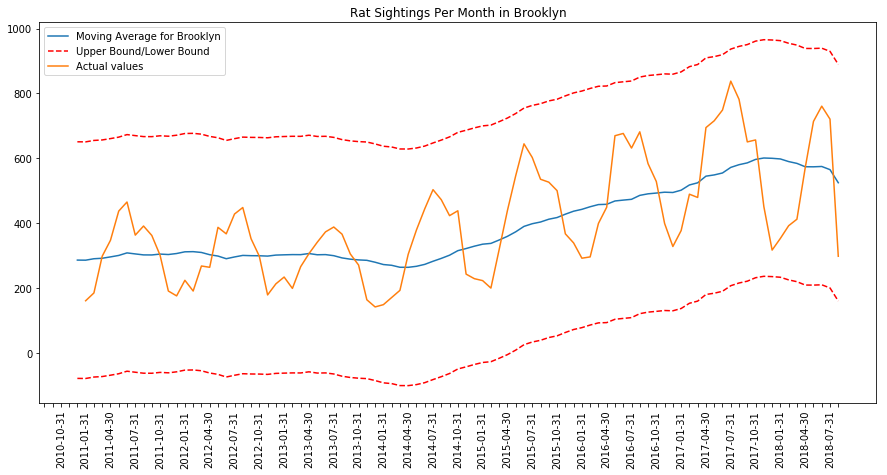

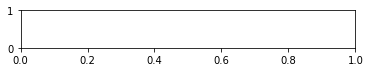

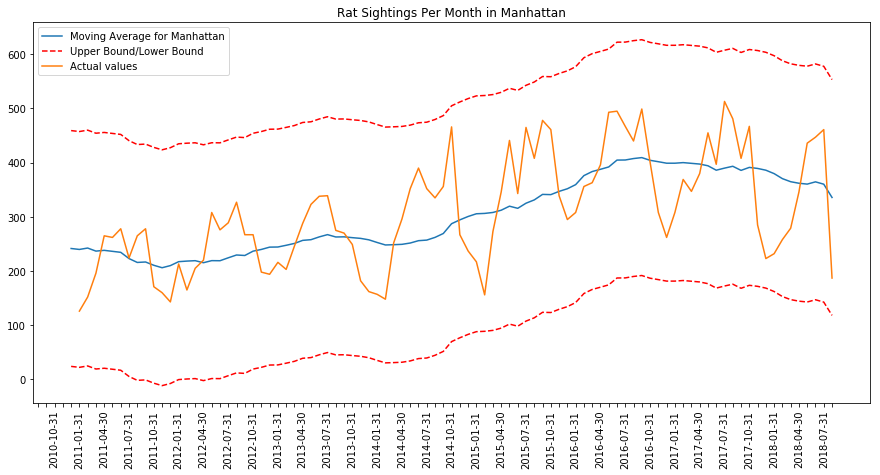

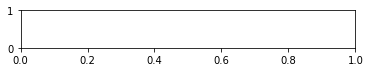

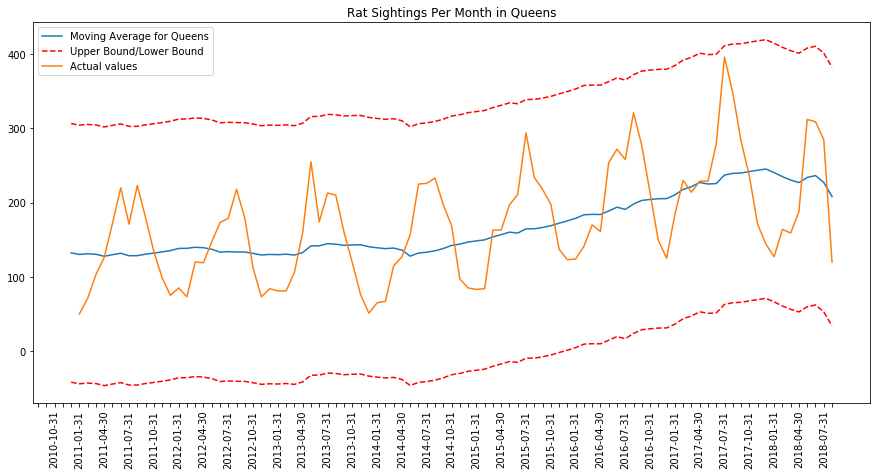

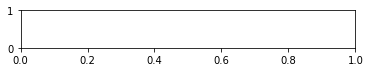

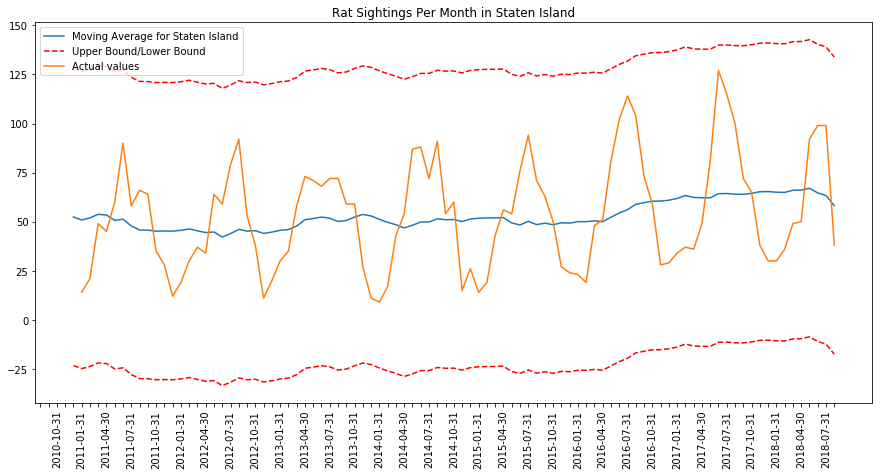

In [13]:
mov_avg_plot(window=12, plot_intervals=True, plot_anomalies=True)

Once again, we're left with only the one anomaly. Our model is showing a pretty good ability at catching the fluctuations and trend of the rat sightings data. If we wanted to make it slightly better, we could implement a ...

---

#### Exponential Smoothing

A weighted average modifies the moving average formula giving more recent observations more importance on the current value than much older ones. This serves as an incremental improvement upon our moving average model. 

However, a further improvement would be to incorporate all available prior observations. This seems like a good approach, right? Say for example that you could control what your memory retained. You don't just say 'I'll remember what happened the last 10 days and the rest is garbage'. However, what happened in the last 10 days might have more significance overall today than 10 years ago so you might give it more importance in your day to day. 

This is called exponential smoothing. Exponential Smoothing *exponentially* decreases the weights assigned to observations as you go further back into historical data. So more recent data is given more importance but old data is not discarded either. 

More specifically this is called single exponential smoothing. However, in the case where you have data exhibiting some sort of trend  (up or down), it makes sense to use double exponential smoothing. This type of exponential smoothing is able to detect upward or downward patterns in the time series data. 

However, when data also exhibits a seasonality aspect, double exponential smoothing isn't necessarily the best. For example, if you wanted to monitor beach attendance throughout the year, you might find that there is a spike in beach attendance in the summer months and a major dip in the winter months. If you were using double expnential smoothing, you are going to react late to these sort of spikes. So you may still be using April attendance values to predict May attendance numbers. When you recongnize the shift, you'll account for it maybe mid or late May but you may overcompensate in your expectations. 

Even more specific there are key holidays in May that you may miss and overcompensate afterwards. These are seasonal components that double exponential smoothing will miss. This is where - wait for it - triple exponential smoothing comes in. Triple exponential smoothing treats these seasonal components separate from others. So for example, you wouldn't use March, April beach attendance to predict May as much but rather you would use the last May beach attendance numbers to assess this May. 

This type of smoothing is able to detect distinct seasonal compnents and better account for unique spikes that occur periodically. So let's skip directly to this type of smoothing since we have seasonal data exhibiting a trend. 

In [14]:
time_data.head()

Borough       Date  Count
0   Bronx 2010-01-31    121
1   Bronx 2010-02-28    110
2   Bronx 2010-03-31    162
3   Bronx 2010-04-30    180
4   Bronx 2010-05-31    183

In [15]:
from statsmodels.tsa.api import ExponentialSmoothing

# define a function to get train/test data
def time_train_test_split(data=time_data, years_to_train=4):
    
    """data is the same time series data that we have been
    working with to this point with columns 'Borough', 'Date',
    and 'Count'.
        years_to_train is a parameter that can take in the num
    of years you want to train the data on. This will go to the
    available years that we have to train on minus one so that there
    is always at least one year to test on. The default is set to 
    4.
    """
    
    # we need a separate col for year
    def get_year_col(data=data):
        
        def get_year(row):
            
            # conv timestamp to str, split, grab year
            return str(row).split("-")[0]
        
        return data.Date.map(get_year)
    
    # add col to dataset
    data["Year"] = get_year_col()
    
    # assess if user input for years_to_train exceeds available years
    if years_to_train > data.Year.nunique():
        
        years_to_train = (data.Year.nunique() - 1)
        
    # define years in train/test sets
    years = [*data.Year.unique()]
    train_years = years[:years_to_train]
    test_years = years[years_to_train:]
    
    # make split
    train_data = (data[data.Year.isin(train_years)]
              .reset_index(drop=True)
             )
    test_data = (data[data.Year.isin(test_years)]
                 .reset_index(drop=True)
                )
    
    return train_data, test_data

train_data, test_data = time_train_test_split()
train_data.head()


Borough       Date  Count  Year
0   Bronx 2010-01-31    121  2010
1   Bronx 2010-02-28    110  2010
2   Bronx 2010-03-31    162  2010
3   Bronx 2010-04-30    180  2010
4   Bronx 2010-05-31    183  2010

In [16]:
data = time_data

def get_year_col(data=data):

    def get_year(row):

        # conv timestamp to str, split, grab year
        return str(row).split("-")[0]

    return data.Date.map(get_year)

# add col to dataset
data["Year"] = get_year_col()
data.head()

Borough       Date  Count  Year
0   Bronx 2010-01-31    121  2010
1   Bronx 2010-02-28    110  2010
2   Bronx 2010-03-31    162  2010
3   Bronx 2010-04-30    180  2010
4   Bronx 2010-05-31    183  2010

In [17]:
[*data.Year.unique()][8:]

['2018']

---

Let's verify the split worked...

In [18]:
print([*train_data.Year.unique()])
print([*test_data.Year.unique()])

['2010', '2011', '2012', '2013']
['2014', '2015', '2016', '2017', '2018']


---

#### Now let's create our Holt Winters Model and Visualize the results

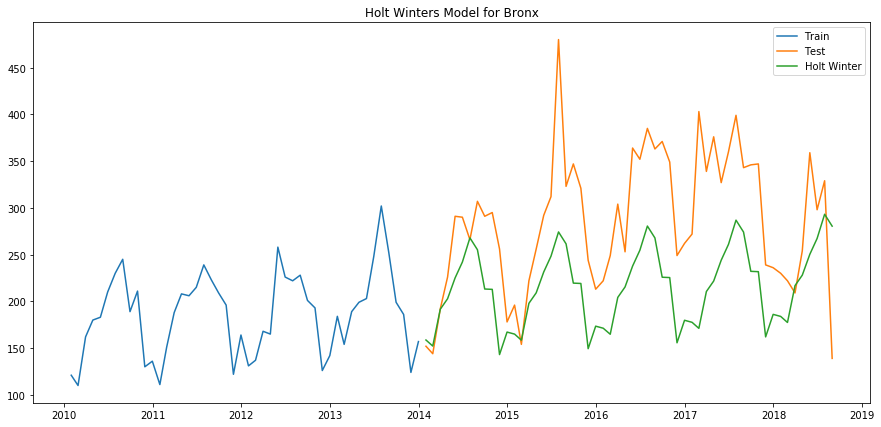

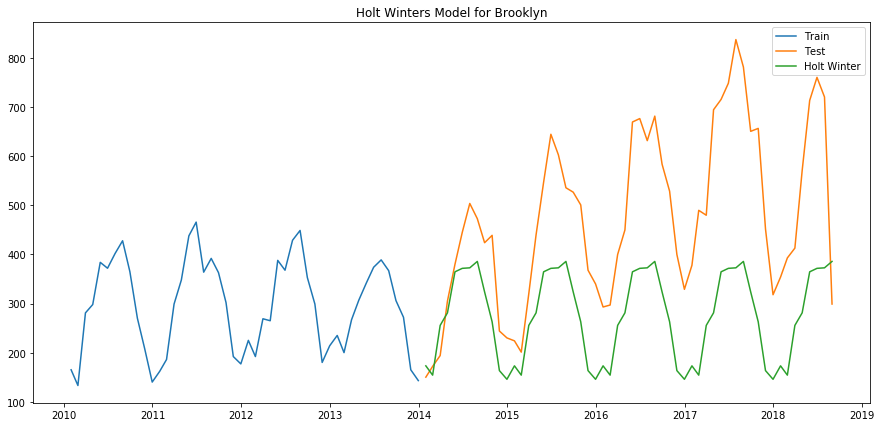

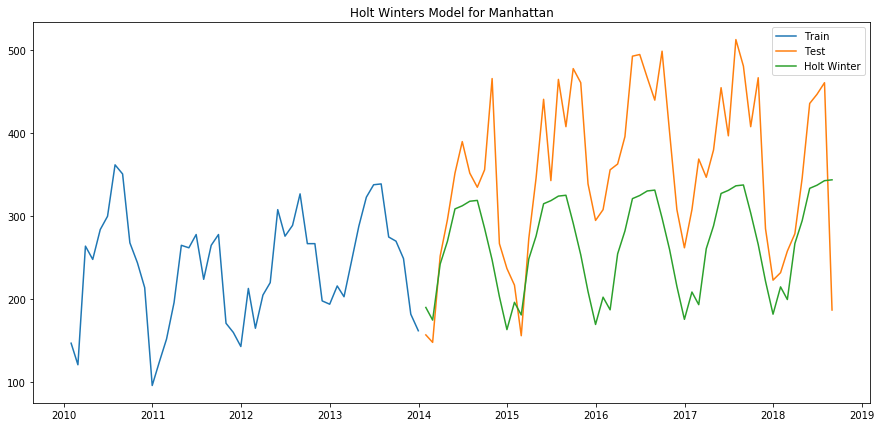

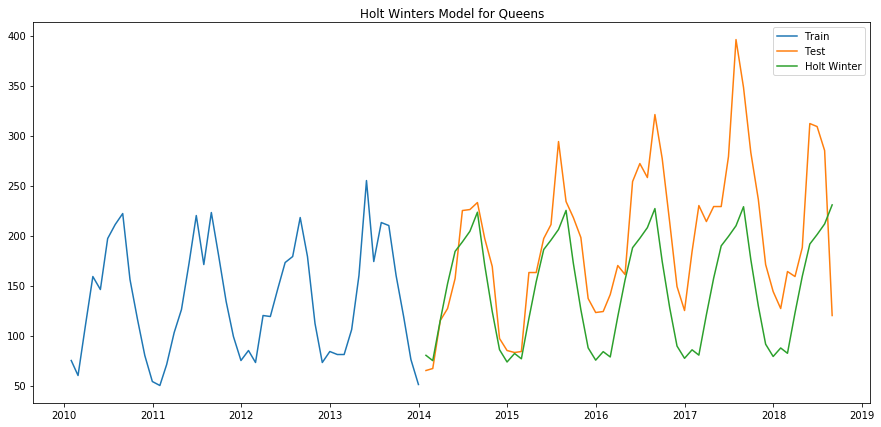

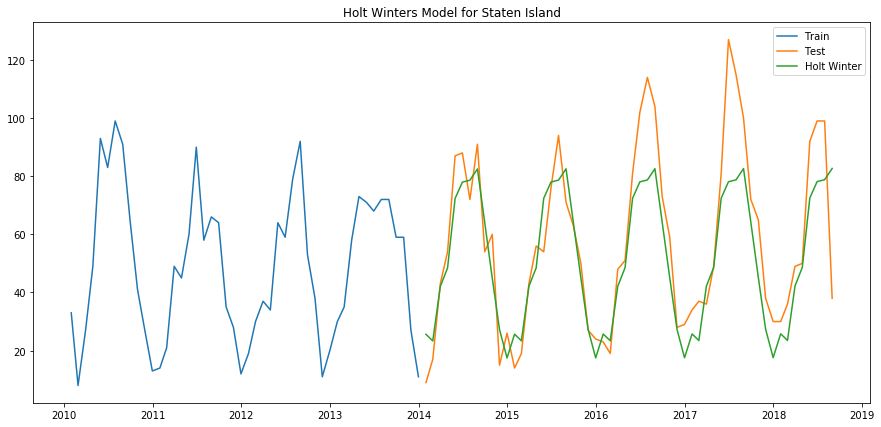

In [19]:
def holt_winters_model(train=train_data, test=test_data, seasonal_components=12):
    
    """ train_data - the data subsetted in the previous func
    to train the model on.
        test data - the data to evaluate the results of the model
    against. 
        seasonal_components - a parameter within the exponential 
    smoothing model to spicfy the number of seasonal components. 
    This will be default to 4 for the four seasons typically
    experienced in NYC. 
    
    """
    # container for errors
    errors = []
    # run the model on each borough in nyc
    for boro in train.Borough.unique():
        
        #subset data 
        train_boro = (train
                 .query("Borough == '%s'" %boro)
                 .reset_index(drop=True)
                 .sort_values("Date")
                 .set_index(["Date"])
                )
        test_boro = (test
                .query("Borough == '%s'" %boro)
                .reset_index(drop=True)
                .sort_values("Date")
                .set_index("Date")
               )

        yhat_avg = test_boro.copy()

        # fit the model
        model = ExponentialSmoothing(np.asarray(train_boro.Count), 
                                     seasonal_periods=seasonal_components,
                                     trend="add",
                                     seasonal="add",
                                    ).fit()

        # create predictions
        yhat_avg["Holt_Winter"] = model.forecast(len(test_boro))

        # create plot
        plt.figure(figsize=(15,7))
        plt.plot(train_boro.Count, label="Train")
        plt.plot(test_boro.Count, label="Test")
        plt.plot(yhat_avg.Holt_Winter, label="Holt Winter")
        plt.legend(loc="best")
        plt.title("Holt Winters Model for %s" %boro)
        plt.show()
        
        # get errors
        errors.append(mean_absolute_error(test_boro.Count,
                                          yhat_avg.Holt_Winter
                                         )
                     )
    return errors
    
# run model
errors = holt_winters_model()

In [20]:
# errors
print("The average error generated by the Holt Winters model is %f" %pd.Series(errors).mean()+".\n")
errors

The average error generated by the Holt Winters model is 89.645190.



[76.07974942063801,
 206.30056944617598,
 97.48669347195967,
 56.58027037637591,
 11.778665990887633]

Great. So if you'll remember, our error from the prophet model on average was 52. I have defined 12 seasonal components as we have 12 months in the data. It is possible that a higher seasonal component number could help describe the data more accurately. 

---

#### Let's say there are 16 Seasonal Components ...

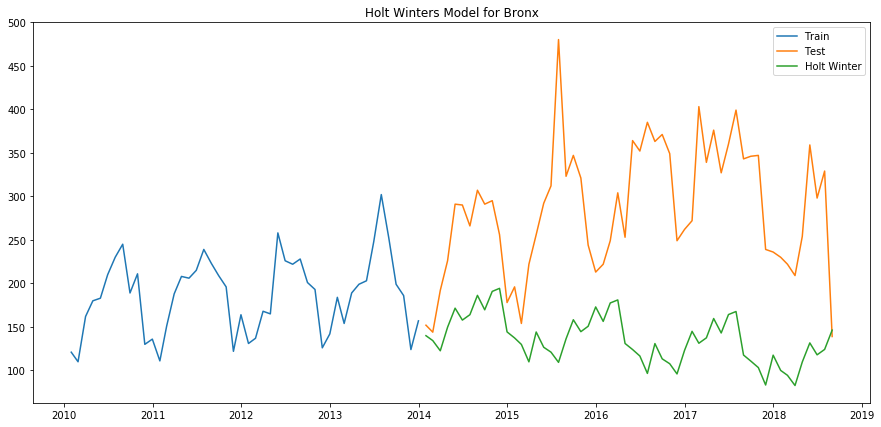

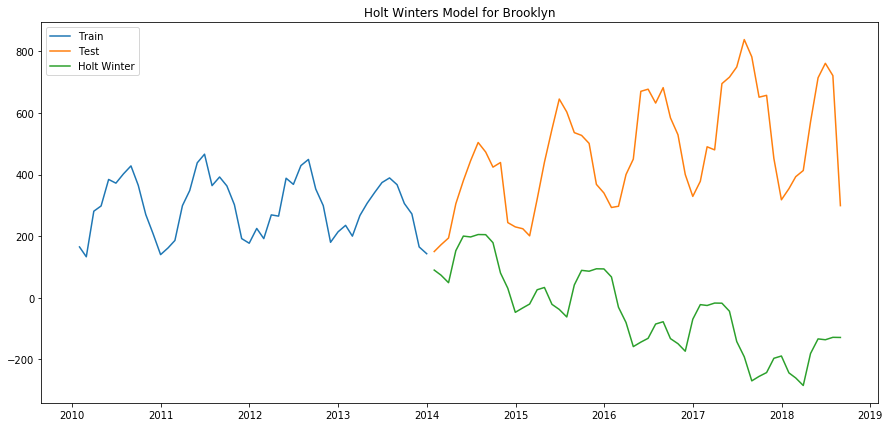

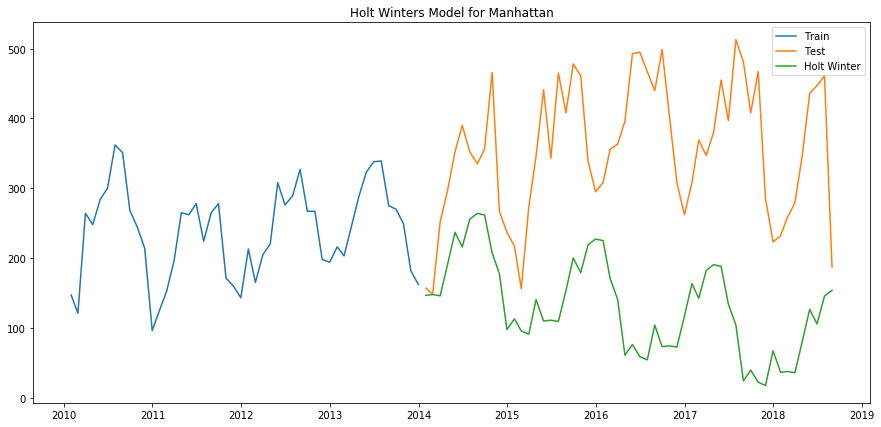

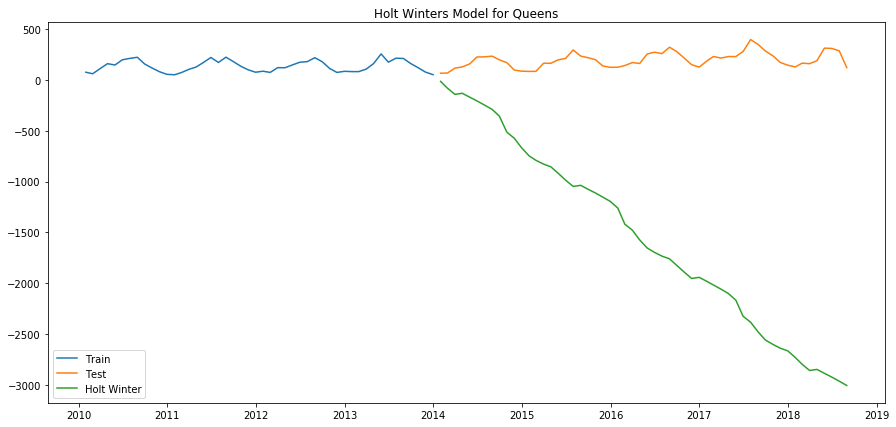

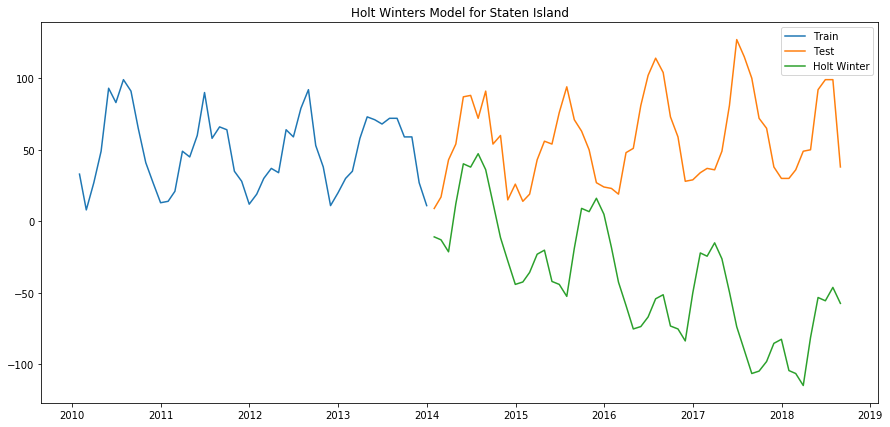

The average error generated by the Holt Winters model is 546.135879.



[150.0643180230497,
 520.6789855117884,
 224.7089292719433,
 1736.7301288606006,
 98.49703568217407]

In [21]:
errors = holt_winters_model(seasonal_components=16)
# errors
print("The average error generated by the Holt Winters model is %f" %pd.Series(errors).mean()+".\n")
errors

As you can see, it doesn't. In fact, using 13 or 11 creates notably off results as well. 

----

#### Facebook Prophet Model

The average error generated by the Prophet model is 105.508210.

[76.93676009274643, 310.5457595263218, 72.69707520157556, 56.77039502533302, 10.591062216816166]


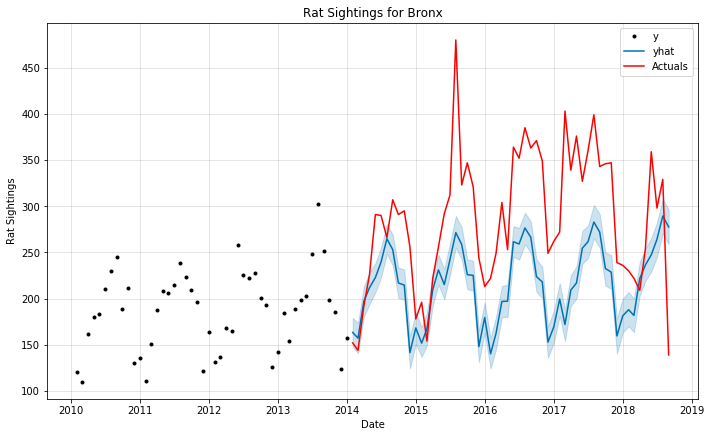

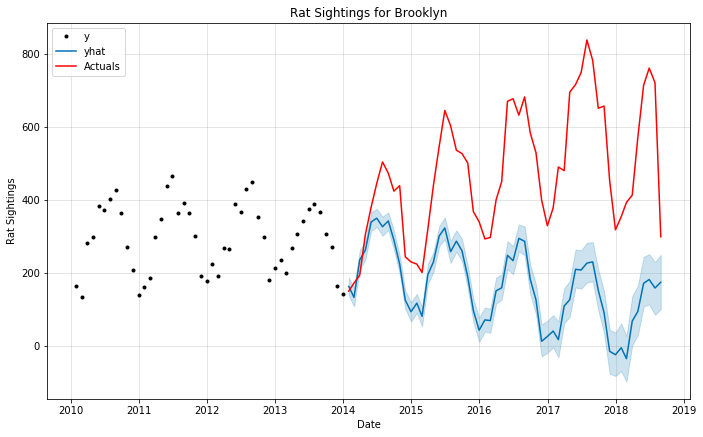

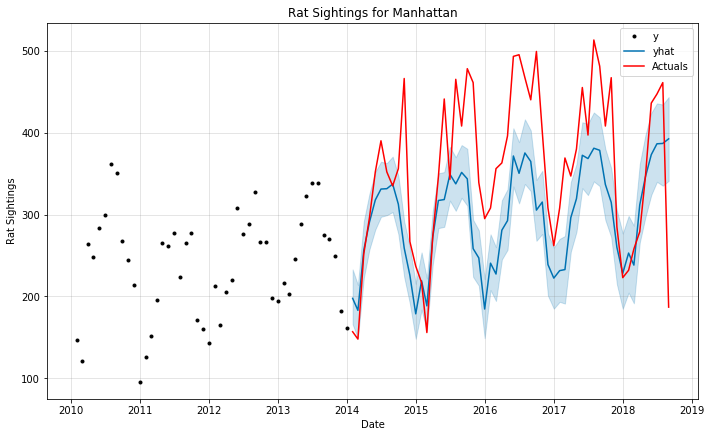

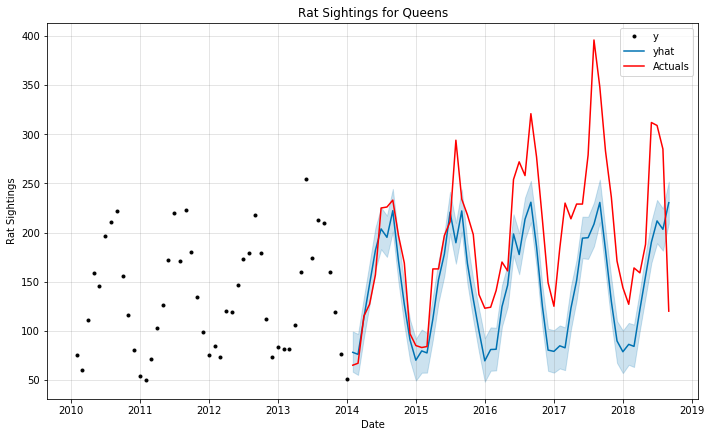

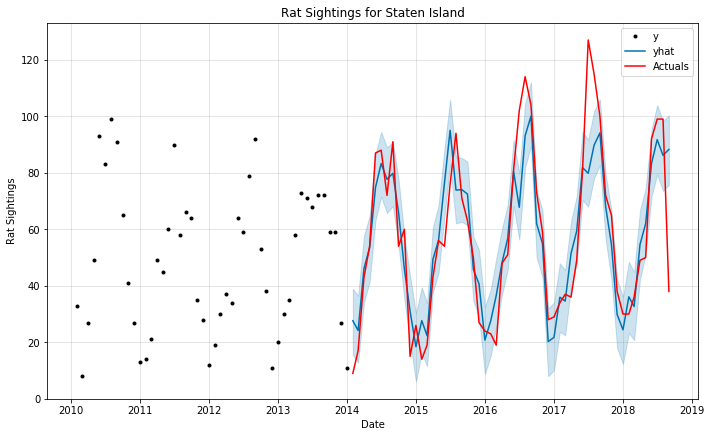

In [22]:
import fbprophet

def prophet(data=time_data, changepoint_param = 0.15, years_to_train=4):
    
    """
    
    """
    # get train/test data
    train_data, test_data = time_train_test_split(data=data,
                                                  years_to_train=years_to_train
                                                 )
    
    # container for errors
    errors = []
    # run the model on each borough in nyc
    for boro in train_data.Borough.unique():
        
        #subset data 
        train_boro = (train_data
                      .query("Borough == '%s'" %boro)
                      .sort_values("Date")
                      .reset_index(drop=True)
                      .rename(columns = {"Date":"ds",
                                         "Count":"y"
                                        }
                             )
                     )
        test_boro = (test_data
                     .query("Borough == '%s'" %boro)
                     .sort_values("Date")
                     .reset_index(drop=True)
                     .rename(columns = {"Date":"ds",
                                         "Count":"y"
                                        }
                             )
                    )
        
        # instantiate the model
        model = fbprophet.Prophet(
            changepoint_prior_scale=changepoint_param,
            weekly_seasonality=False,
            daily_seasonality=False
        )
        # fit the model
        model.fit(train_boro)
        
        # make predictions on test data
        forecast = (model
                    .predict(test_boro)
                   )
        
        # get error value
        errors.append(mean_absolute_error(forecast.yhat, test_boro.y))
        
        # visualize projections
        model.plot(forecast,
                   xlabel="Date",
                   ylabel="Rat Sightings"
                  )
        # reformat test_boro
        test_boro = test_boro.set_index(["ds"])
        plt.plot(test_boro.y, "r", label="Actuals")
        plt.legend(loc="best")
        plt.title("Rat Sightings for %s" %boro)
        
    return errors
        
errors = prophet()
print("The average error generated by the Prophet model is %f" %pd.Series(errors).mean()+".\n")
print(errors)

---

#### So,  how did it do?

It looks like the model was able to do decent for Staten Island and okay for Manhattan. However, it struggled in particular with Brooklyn. It turns out the last year that the model was trained on for Brooklyn had a reduction in rat sightings. However, this one of year ended up being a one off and Brooklyn ends up seeing much more rat sightings. 

The numbers do confirm the visual analysis as the average mean absolute error was 105.02 compared to the earlier value of 89. 

Let's play around with the `years_to_train` parameter and see if we get better results.

The average error generated by the Prophet model is 60.762500.

[88.13013153739767, 73.29525199432115, 81.42835746742543, 50.455389970012064, 10.50336846296605]


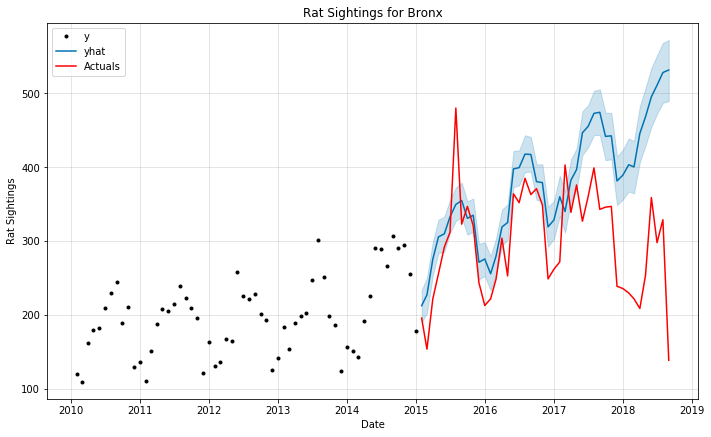

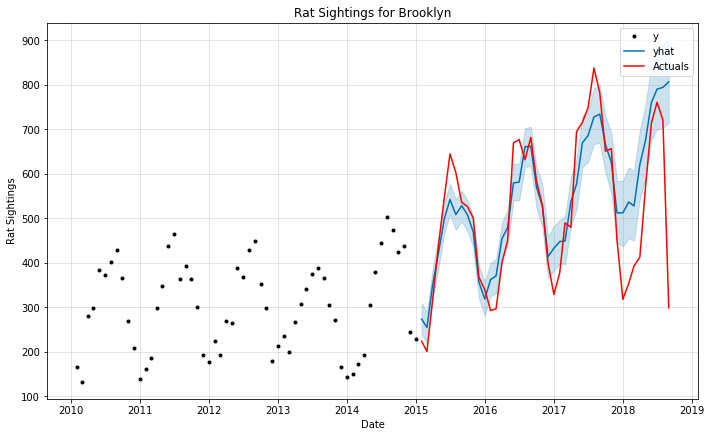

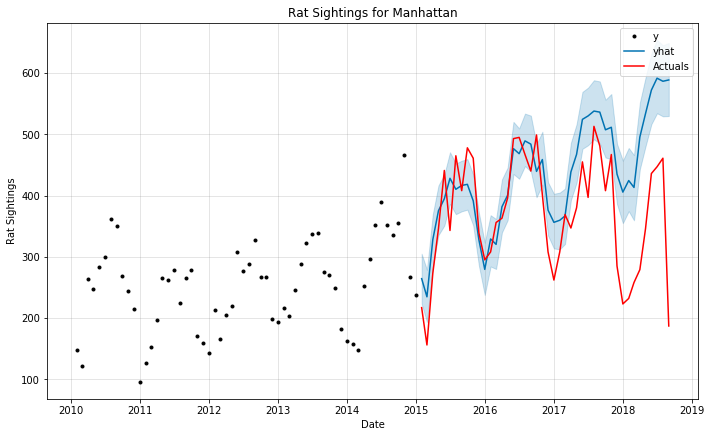

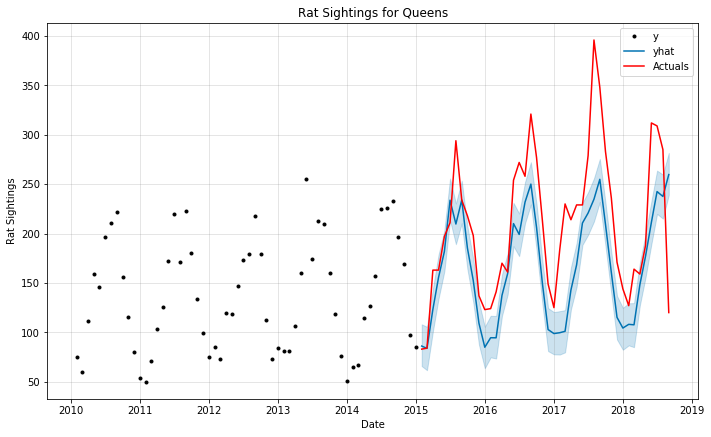

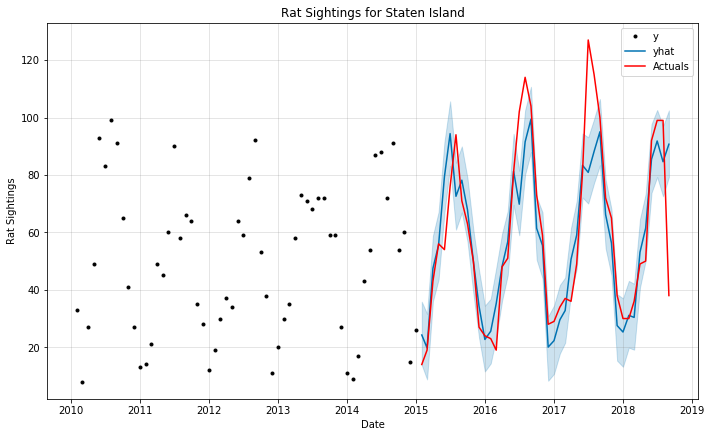

In [23]:
errors = prophet(years_to_train=5)
print("The average error generated by the Prophet model is %f" %pd.Series(errors).mean()+".\n")
print(errors)

The average error generated by the Prophet model is 67.914696.

[76.7812562722917, 116.52946564603887, 99.7280745747534, 32.0566324922729, 14.478049507301911]


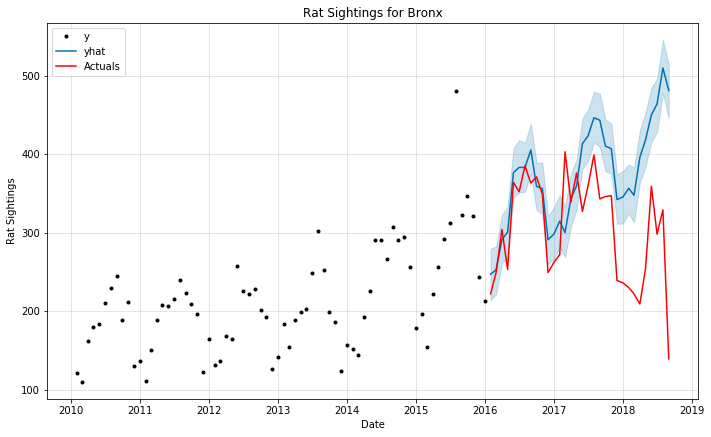

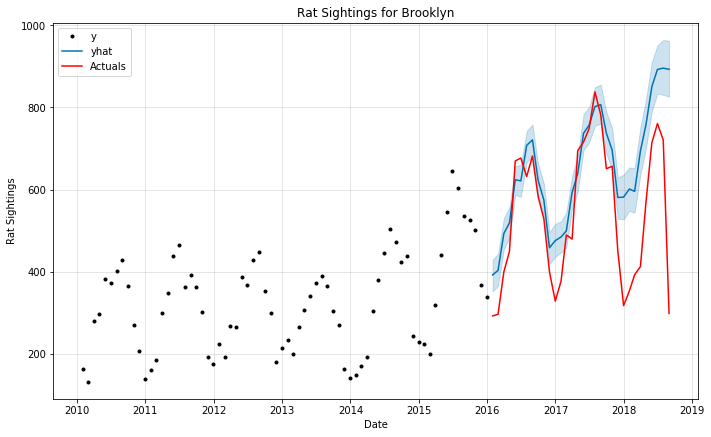

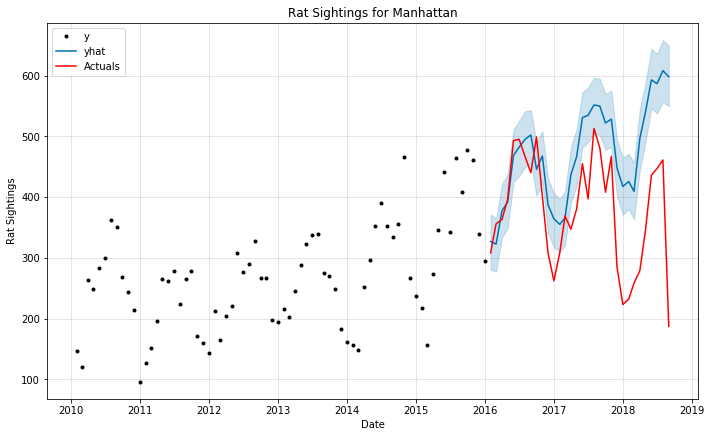

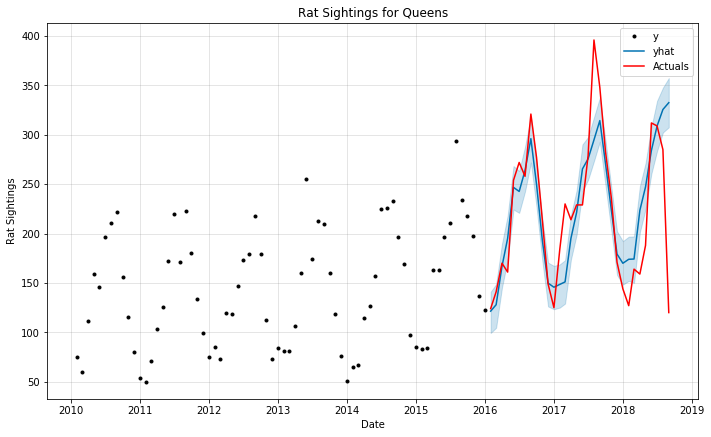

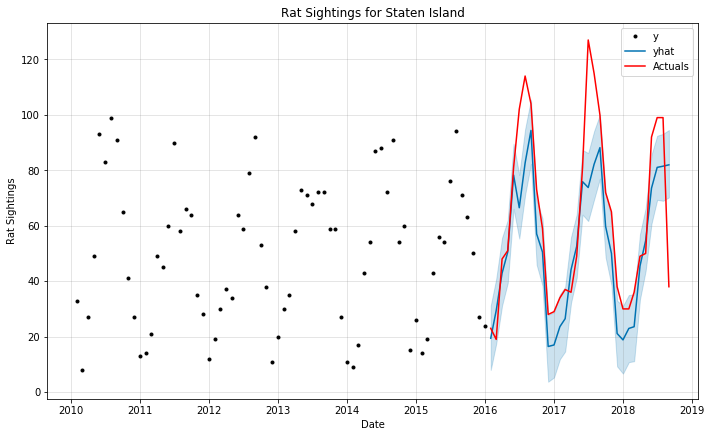

In [24]:
errors = prophet(years_to_train=6)
print("The average error generated by the Prophet model is %f" %pd.Series(errors).mean()+".\n")
print(errors)

---

#### Major Improvement. 

Interestingly, the model performed slightly worse with more years to train on due to the fluctuations within this data. 

This could possibly be enhanced with further tuning to the model. It is worth wondering how much is the improvement in performance worth. Though this model has a better error value, it visual appears to be overestimating certain trends in the data and at times unable to recooperate. The Holt-Winters model may have performed worse by the metric at hand but certainly did a better job in generalizing the data. Tuning and cross validation may reveal more about the path to proceed with. However, we're going to take a different direction ...

#### Supervised Learning

Time series problems come about frequently in data science and can offer interesting insights into trends and patterns as well as an idea of future projections. 

However, they can offer a limited amount of ways to go in modeling and forecasting the data. There are plently of other models that I didn't utilize in this notebook but even considering the options, it can feel quite constricting in how to proceed with the data. So we're going to manipulate the data to form a supervised learning problem. This will give us a greater disposal of models to work with. 

In [25]:
time_data.head()

Borough       Date  Count  Year
0   Bronx 2010-01-31    121  2010
1   Bronx 2010-02-28    110  2010
2   Bronx 2010-03-31    162  2010
3   Bronx 2010-04-30    180  2010
4   Bronx 2010-05-31    183  2010

---

#### Transforming the Data

When implementing supervised learning, you have a set of inputs, *x*, and outputs, *y*. This creates a function *y = f(x)* where the function is a bit of a black box that we are attempting to learn. So, we take the inputs and outputs and train our model to learn the relationship that exist. There is significant research into this realm that we aren't going to dive in but we can frame our time series data to be outputs of the value preceding it. 

Let's take a look.

In [26]:
time_data.query("Borough == 'Staten Island'").head()

Borough       Date  Count  Year
416  Staten Island 2010-01-31     33  2010
417  Staten Island 2010-02-28      8  2010
418  Staten Island 2010-03-31     27  2010
419  Staten Island 2010-04-30     49  2010
420  Staten Island 2010-05-31     93  2010

---

#### Transforming the Data

So in this case, `33` is the first value. So a `NA` or `0` would precede it and be used as the input that gave this value. Then `33` would be used as the input that would yield `8` due to it being the second value. This can be implemented quite easily using `pandas DataFrame.shift()` method. 

Let's see.

In [27]:
# subset the data
si_data = (time_data
           .query("Borough == 'Staten Island'")
           .reset_index(drop=True)
          )
# view the subsetted data
print(si_data.head())

# shift method
si_data["t-1"] = si_data.Count.shift()

# view
si_data.head()

         Borough       Date  Count  Year
0  Staten Island 2010-01-31     33  2010
1  Staten Island 2010-02-28      8  2010
2  Staten Island 2010-03-31     27  2010
3  Staten Island 2010-04-30     49  2010
4  Staten Island 2010-05-31     93  2010


Borough       Date  Count  Year   t-1
0  Staten Island 2010-01-31     33  2010   NaN
1  Staten Island 2010-02-28      8  2010  33.0
2  Staten Island 2010-03-31     27  2010   8.0
3  Staten Island 2010-04-30     49  2010  27.0
4  Staten Island 2010-05-31     93  2010  49.0

#### Transforming the Data

This is also called lagging the data as we are essentially lagging the observations by 1. Since our data is monthly data, everytime we lag, we are lagging back 1 month. The last month can be helpful in describing the next (albeit with limits) but the month before and maybe the month before that as well may be helpful. So let's implement that for each Borough.

In [28]:
def data_lag(data=time_data, n_lags=5):
    
    """ data is going to provide us with our 
    time series data that we have been working with
    to this point. 
        n_lags is a parameter to specify how many lags
    will be included.
        This function will return a dataframe with the
    lag columns included. 
    """
    
    # df to contain new results
    new_df = pd.DataFrame()
    
    # complete the lag for each of the boroughs
    for boro in data.Borough.unique():
        
        boro_data = (data
                     .query("Borough == '%s'" %boro)
                     .reset_index(drop=True)
                    )
        # add each lag column
        for i in range(1,n_lags):
            
            boro_data["t-{}".format(i)] = boro_data.Count.shift(i)
            
        # concat the result to new_df
        new_df = pd.concat([new_df, boro_data])
        
    return new_df.rename(columns={"Count":"t"})

lag_data = data_lag()
lag_data.head()

Borough       Date    t  Year    t-1    t-2    t-3    t-4
0   Bronx 2010-01-31  121  2010    NaN    NaN    NaN    NaN
1   Bronx 2010-02-28  110  2010  121.0    NaN    NaN    NaN
2   Bronx 2010-03-31  162  2010  110.0  121.0    NaN    NaN
3   Bronx 2010-04-30  180  2010  162.0  110.0  121.0    NaN
4   Bronx 2010-05-31  183  2010  180.0  162.0  110.0  121.0

---

#### Now let's model the results & visualize

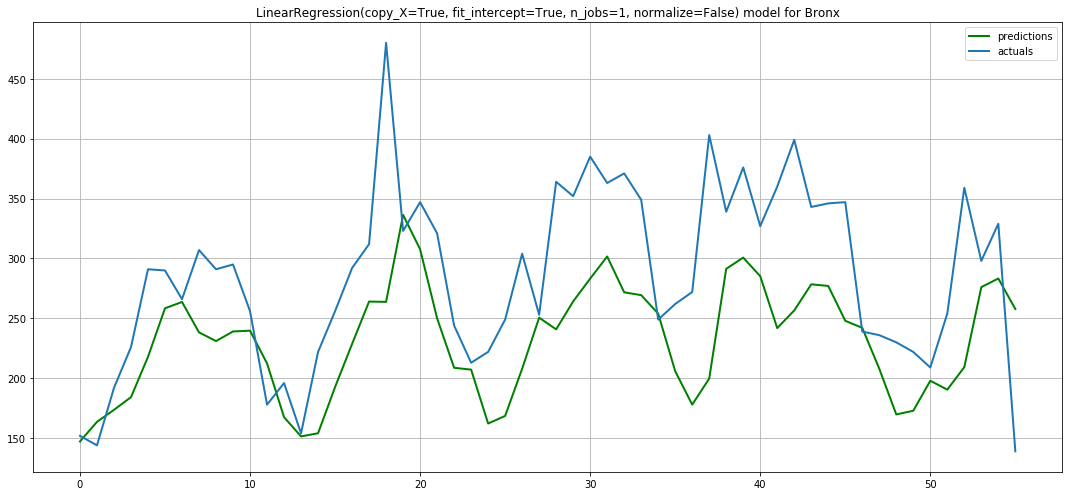

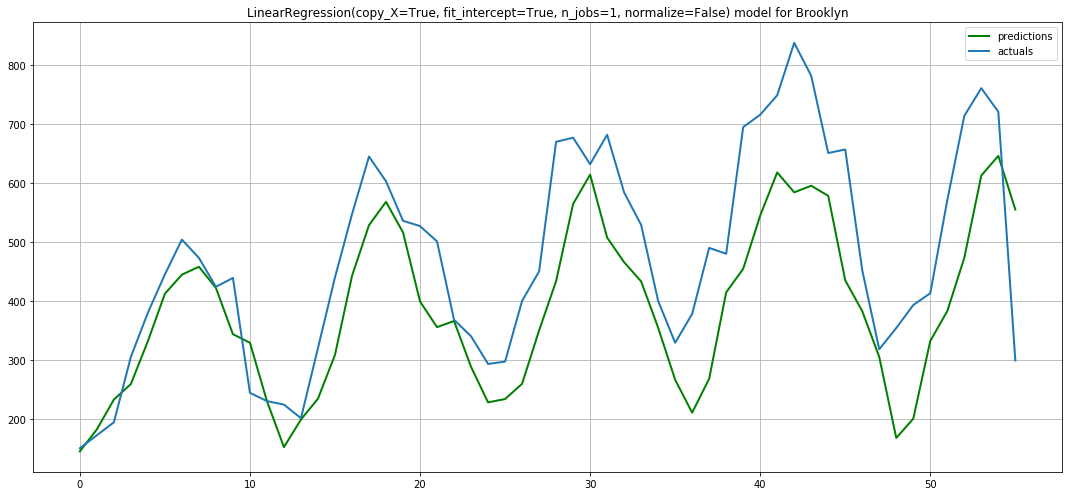

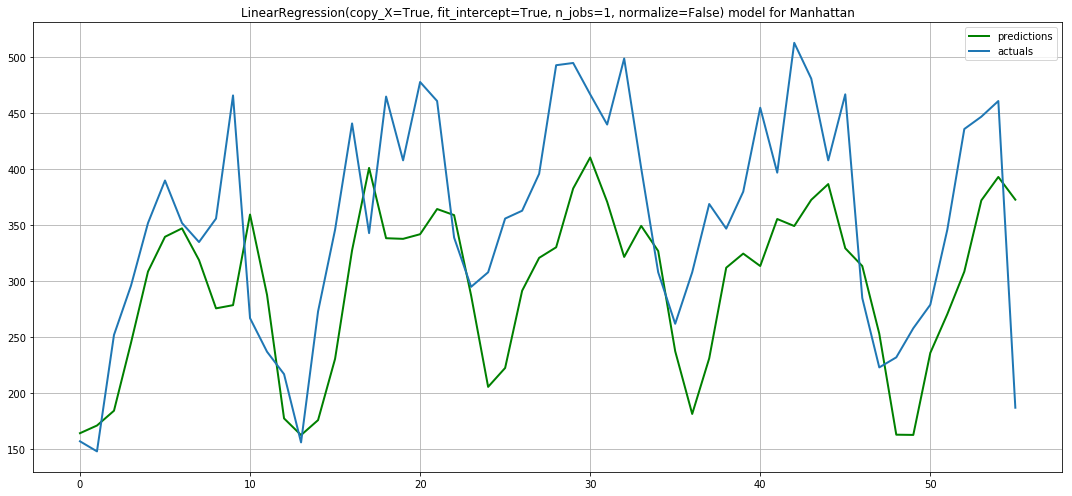

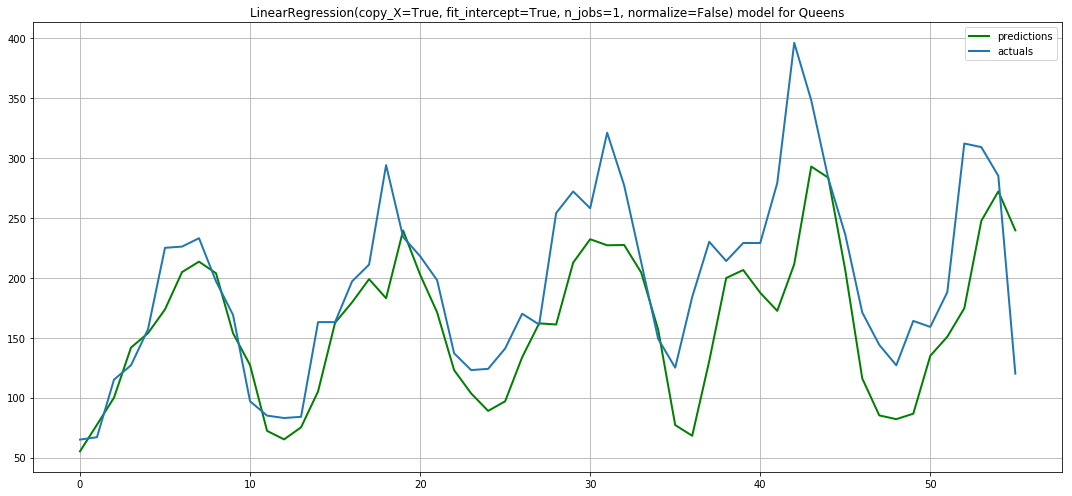

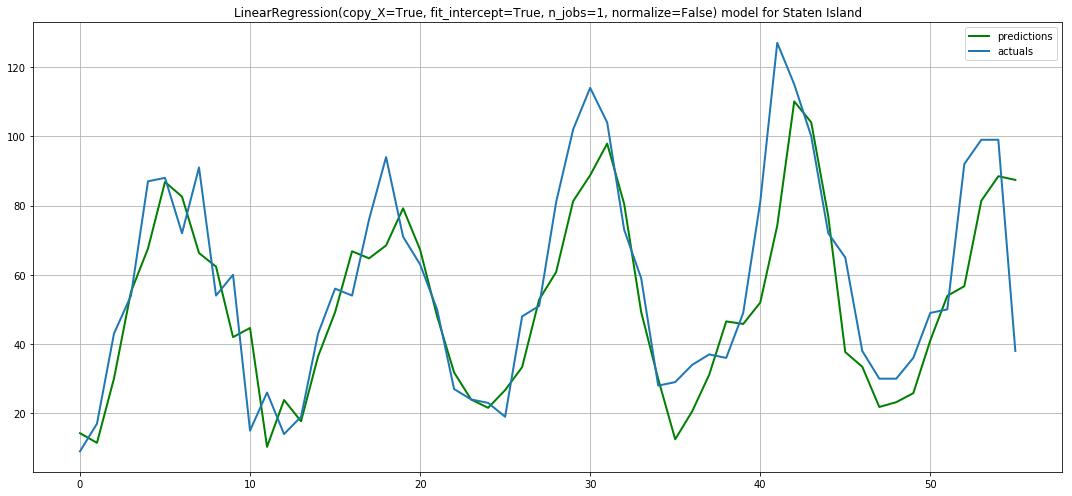

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, TimeSeriesSplit


def modelResults(data=lag_data,model=LinearRegression(), plot_anomalies=False):
    
    """
    """
    
    # fill nas
    data = data.fillna(0)
    
    # split data
    lag_train, lag_test = time_train_test_split(data=data)
    
    # container for error values
    errors = []
    
    # container for models
    models = []
    
    # iterate through each of the boroguhs
    for boro in lag_train.Borough.unique():
        
        boro_train = (lag_train
                      .query("Borough == '%s'" %boro)
                      .reset_index(drop=True)
                     )
        
        boro_test = (lag_test
                     .query("Borough == '%s'" %boro)
                     .reset_index(drop=True)
                    )
        
        # designate y/X
        y_train = boro_train.pop("t")
        X_train = (boro_train
                   .drop(["Borough", "Date", "Year"],
                         axis=1
                        )
                  )
        y_test = boro_test.pop("t")
        X_test = (boro_test
                   .drop(["Borough", "Date", "Year"],
                         axis=1)
                  )
        
        # train model
        model.fit(X_train, y_train)
        
        # predict
        preds = model.predict(X_test)
        
        # errors
        errors.append(mean_absolute_error(y_test,preds))
        
        # append model
        models.append(model)
        
        # plot results
        plt.figure(figsize=(15,7))
        plt.plot(preds, "g", label="predictions", linewidth=2.0)
        plt.plot(y_test.values, label="actuals", linewidth=2.0)
        
        #if plot_intervals:
        plt.title("%s model for %s" %(str(model), boro))
        plt.legend(loc="best")
        plt.tight_layout()
        plt.grid(True)
        
    return models, errors 
        
models, errors = modelResults()

In [30]:
print(errors)
print("The average mean absolute error using the Linear Regression model was %f"%np.mean(errors))

[61.42128391268033, 102.6797142613497, 78.25699326598044, 41.402454849265006, 12.317138744428949]
The average mean absolute error using the Linear Regression model was 59.215517


Great!

---

#### Visualize the feature importance

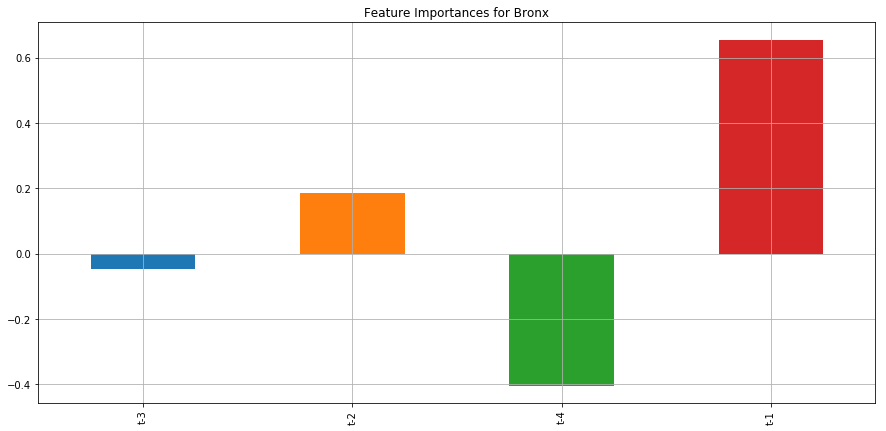

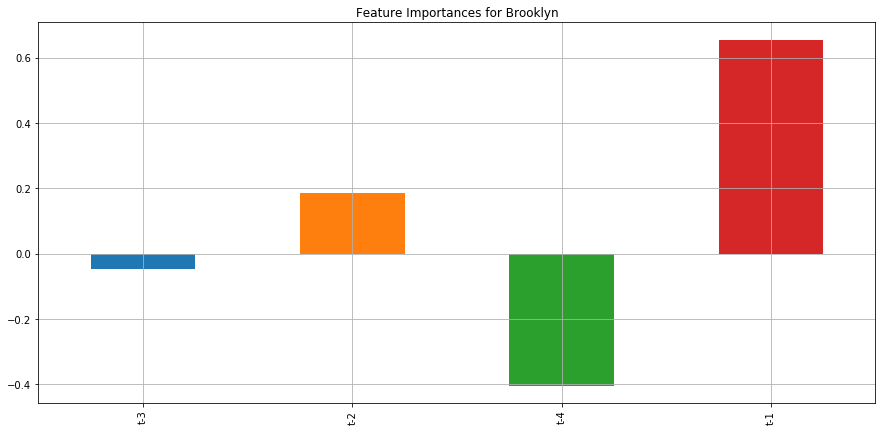

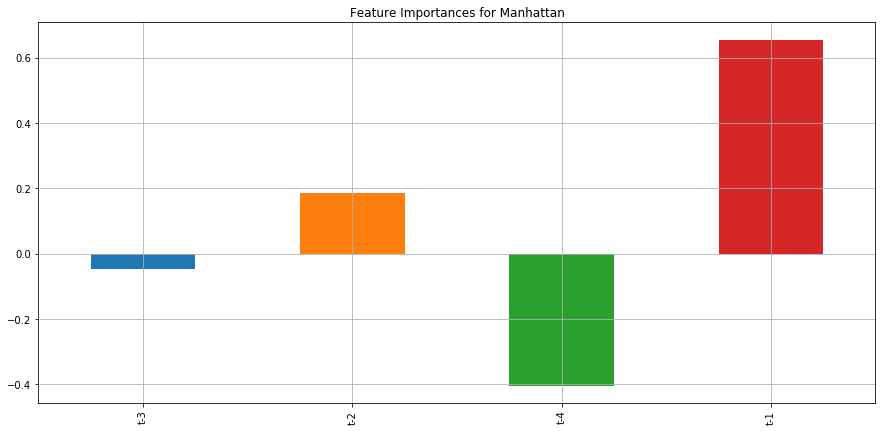

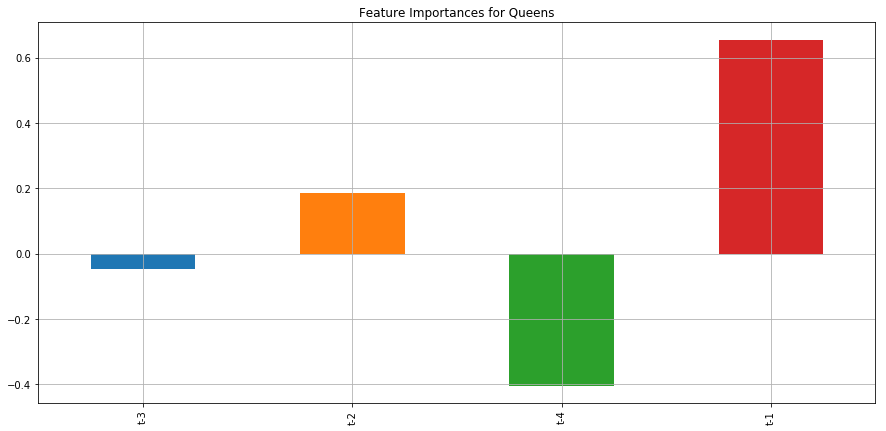

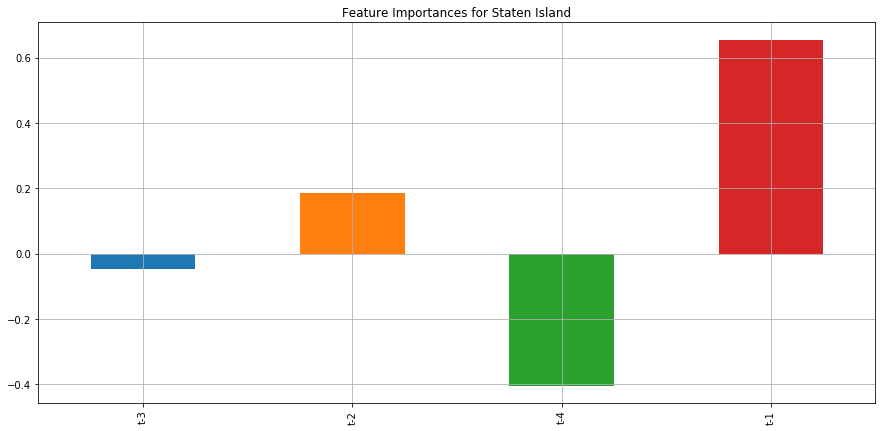

In [31]:
# define list of borough names
boros = [*time_data.Borough.unique()]

# we will provide the names of the features
names = [*(lag_data
           # drop unnecessary feats/target
           .drop(["Borough", "Date", "Year", "t"], axis=1)
           .columns)
        ]

# write func to plot feature importances
def plotFeatImp(models=models, names=names, boros=boros):

    """
    """
    # we outputted the model trained models from the initial
    # func displaying the results
    # now we will iterate through them to see the feat imp
    # assigned to each of the lagged variables
    for model, boro in zip(models, boros):
        
        coefficients = pd.DataFrame(model.coef_, names)
        coefficients.columns = ["coefficients"]
        coefficients["abs"] = (coefficients
                               .coefficients
                               .apply(np.abs)
                              )
        coefficients = (coefficients
                        # we want to see which variables have the
                        # largest impact pos/neg
                        .sort_values(["abs"])
                        .drop(["abs"], axis=1)
                       )
        plt.figure(figsize=(15,7))
        (coefficients
         .coefficients
         .plot(kind="bar")
        )
        plt.title("Feature Importances for %s" %boro)
        plt.grid(True)

# visualize feat importances
plotFeatImp()

Awesome. So we can see that the `t-1` feature has usually a very positive effect on our target `t`. `t-2` usually retains the positive effect on our `t` target while the other two features `t-3` and `t-4` usually have a sizeable negative effect on the target. 

This isn't completely suprising if you think about it. There are many peaks in rat sightings in our data and when you generally lag 4 months behind, you're generally at the peak or valley predicting the opposite result (valley or peak respectively). 

----

#### Will the model perform better lagged two months?

In [32]:
lag_data = data_lag(n_lags=3)
lag_data.head()

Borough       Date    t  Year    t-1    t-2
0   Bronx 2010-01-31  121  2010    NaN    NaN
1   Bronx 2010-02-28  110  2010  121.0    NaN
2   Bronx 2010-03-31  162  2010  110.0  121.0
3   Bronx 2010-04-30  180  2010  162.0  110.0
4   Bronx 2010-05-31  183  2010  180.0  162.0

[56.39077645779237, 87.30951516510842, 69.60455221035222, 33.81230631436487, 14.184550352668753]
The average mean absolute error using the Linear Regression model was 52.260340


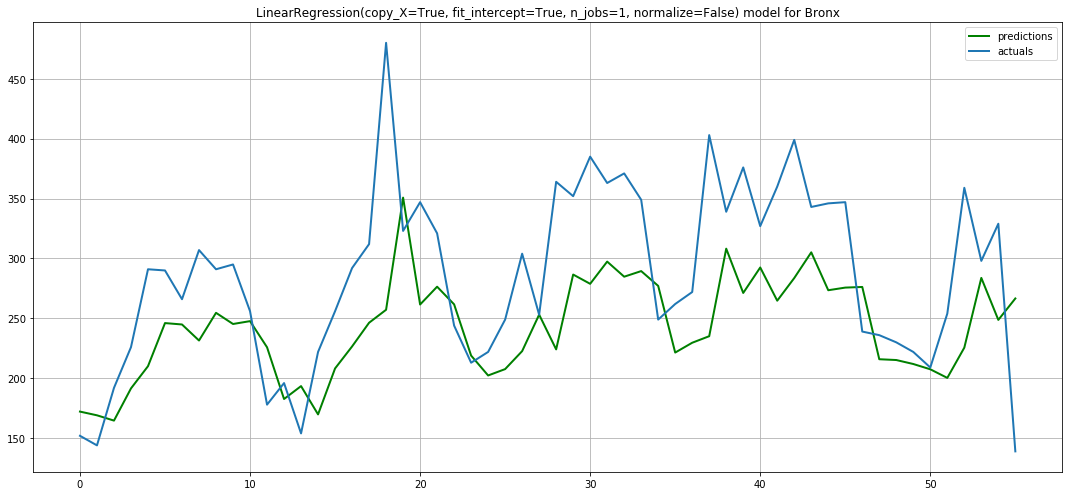

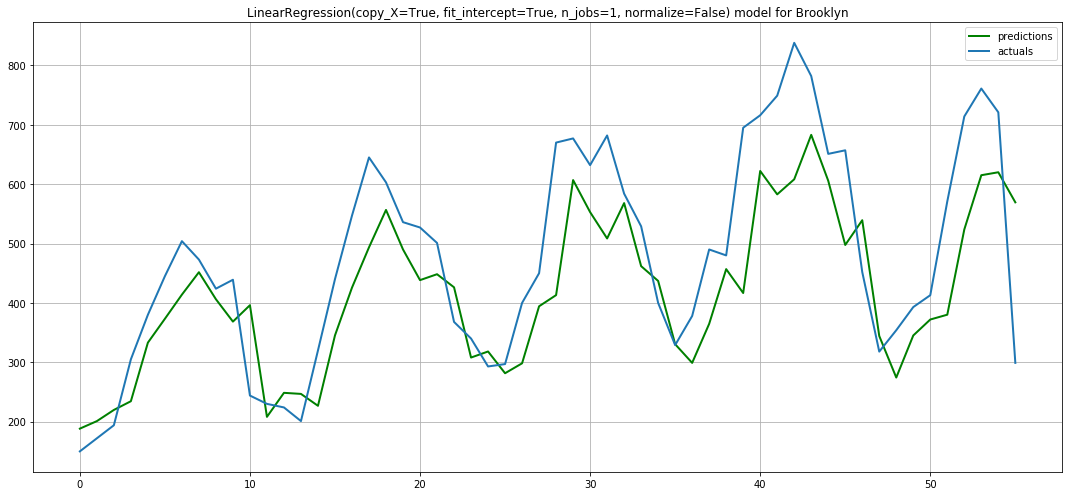

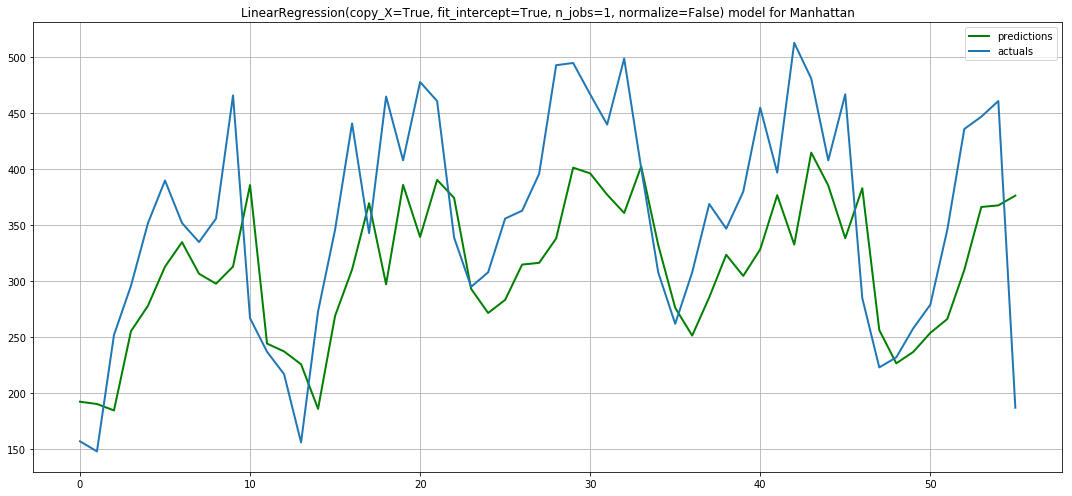

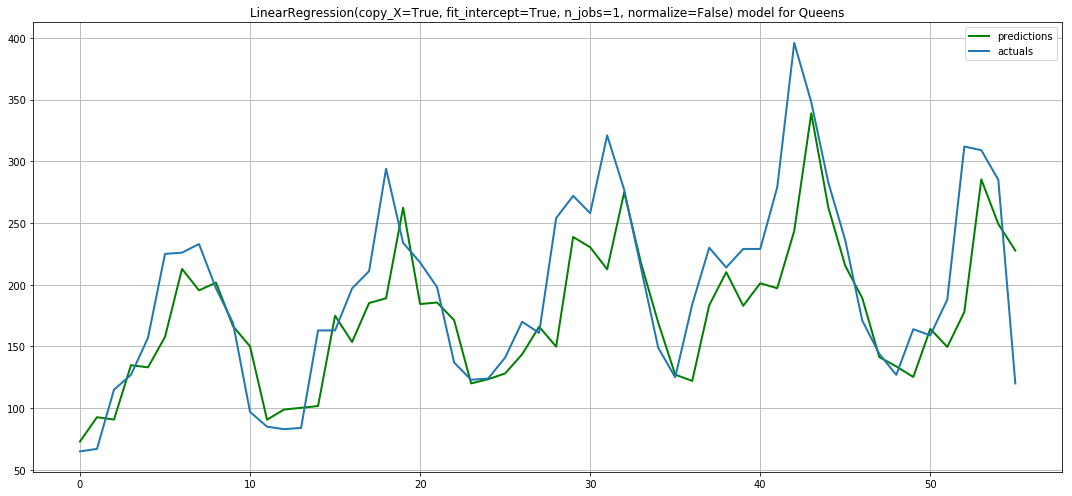

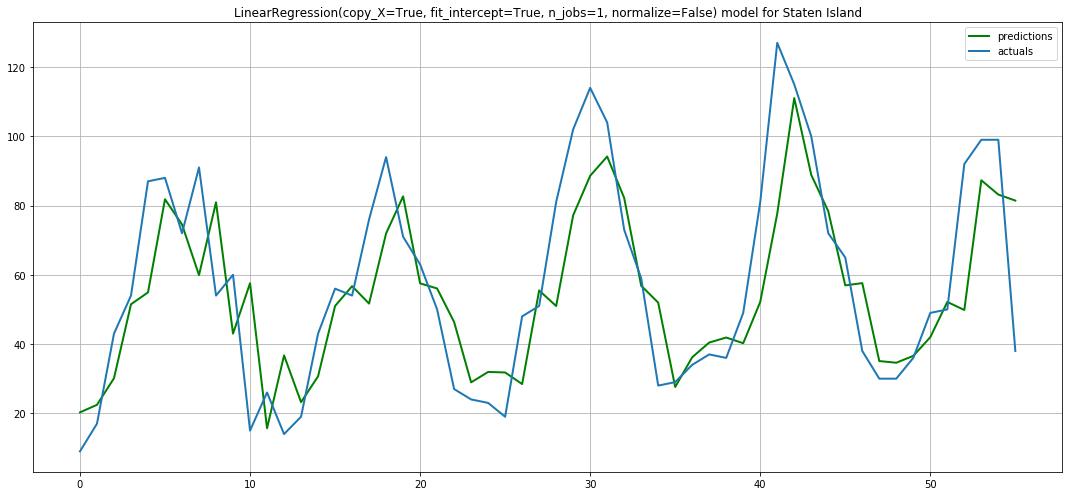

In [33]:
models, errors = modelResults(data=lag_data)
print(errors)
print("The average mean absolute error using the Linear Regression model was %f"%np.mean(errors))


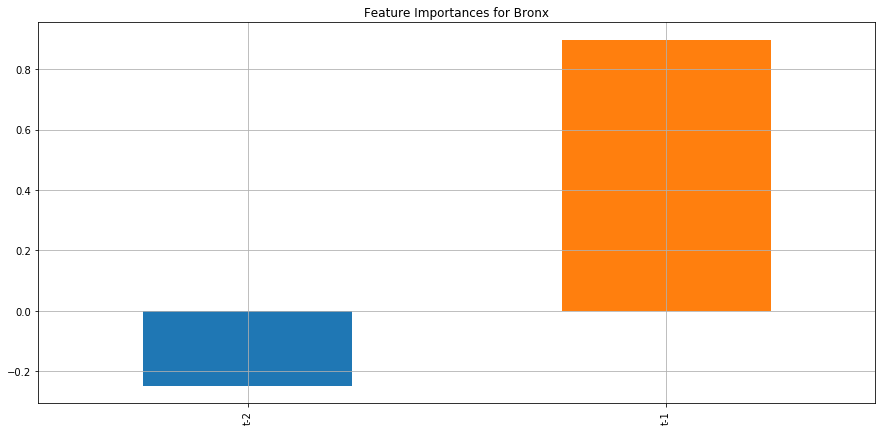

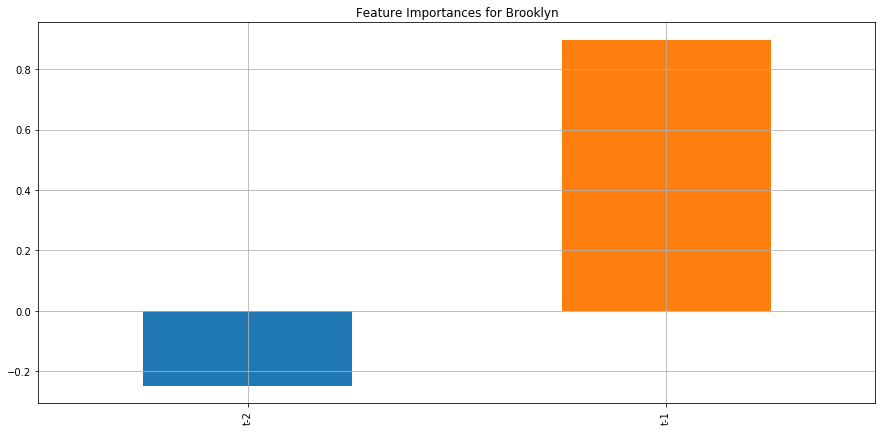

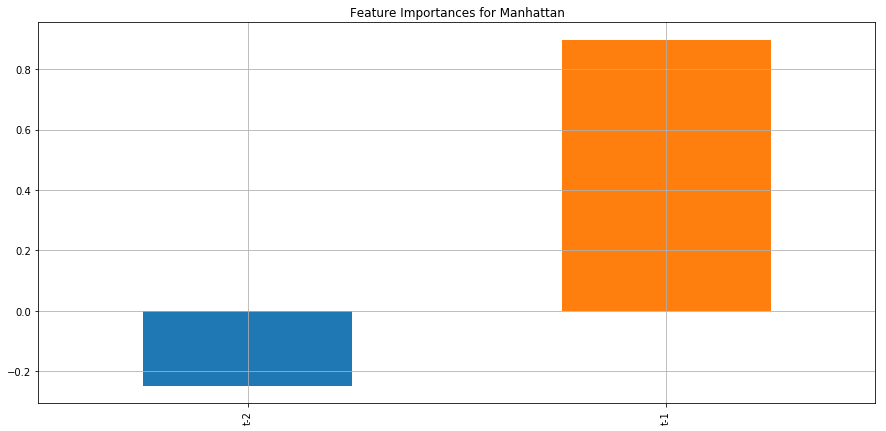

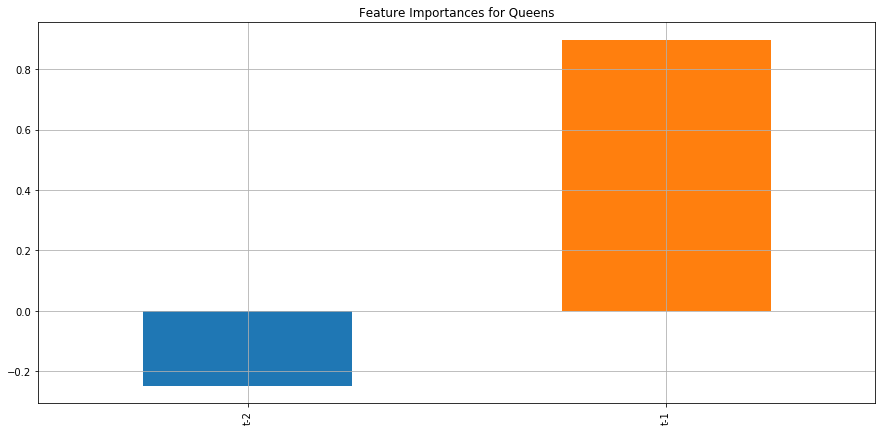

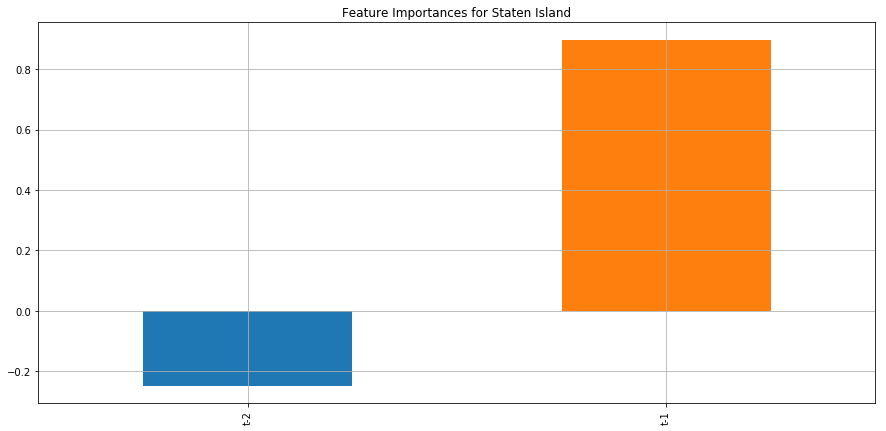

In [34]:
# we will provide the names of the features
names = [*(lag_data
           # drop unnecessary feats/target
           .drop(["Borough", "Date", "Year", "t"], axis=1)
           .columns)
        ]

plotFeatImp(names=names)

---

The model did indeed perform better. Now, the `t-2` feature looks almost relatively unimportant. Let's see how the model performs without this feature.

In [35]:
lag_data = data_lag(n_lags=2)
lag_data.head()

Borough       Date    t  Year    t-1
0   Bronx 2010-01-31  121  2010    NaN
1   Bronx 2010-02-28  110  2010  121.0
2   Bronx 2010-03-31  162  2010  110.0
3   Bronx 2010-04-30  180  2010  162.0
4   Bronx 2010-05-31  183  2010  180.0

[56.2566274580675, 89.75752031142585, 70.1171328128386, 36.47402911102024, 15.108344236246024]
The average mean absolute error using the Linear Regression model was 53.542731


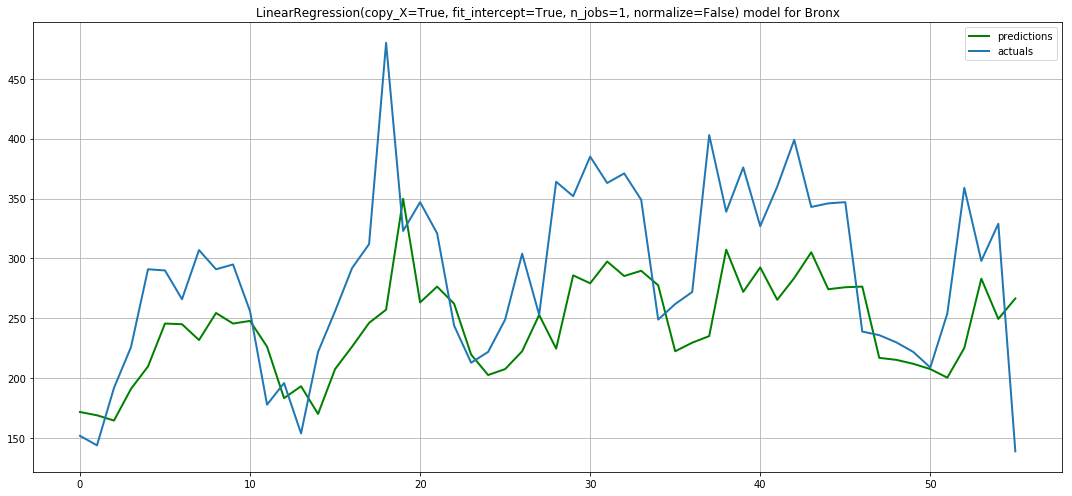

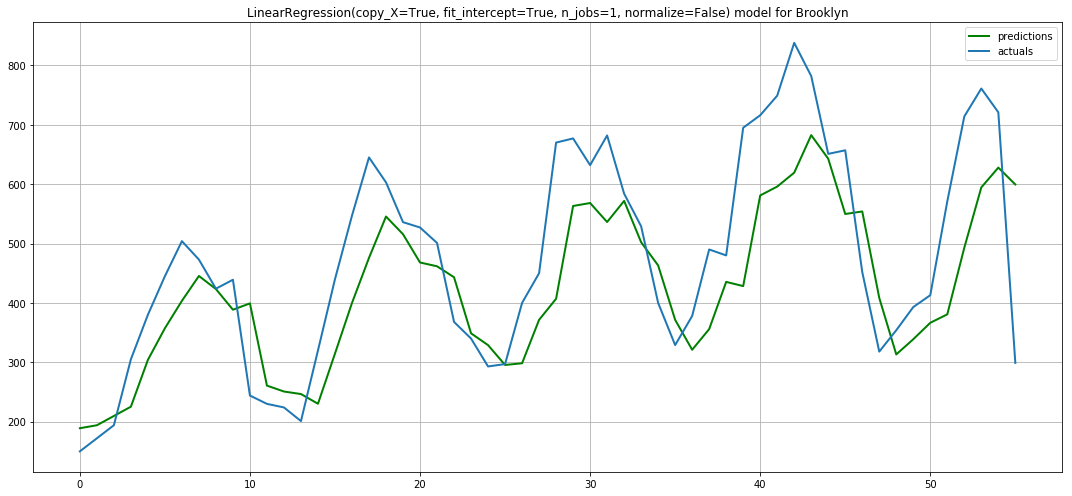

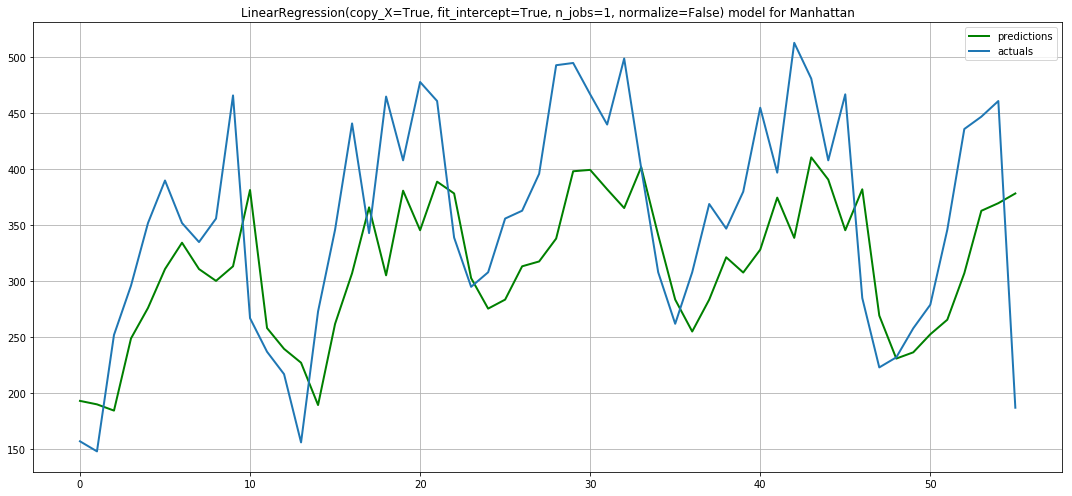

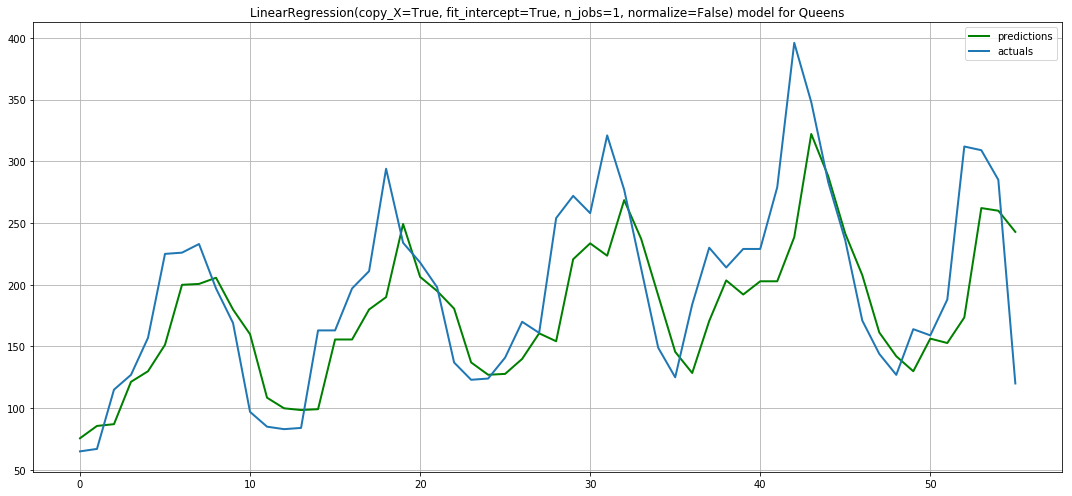

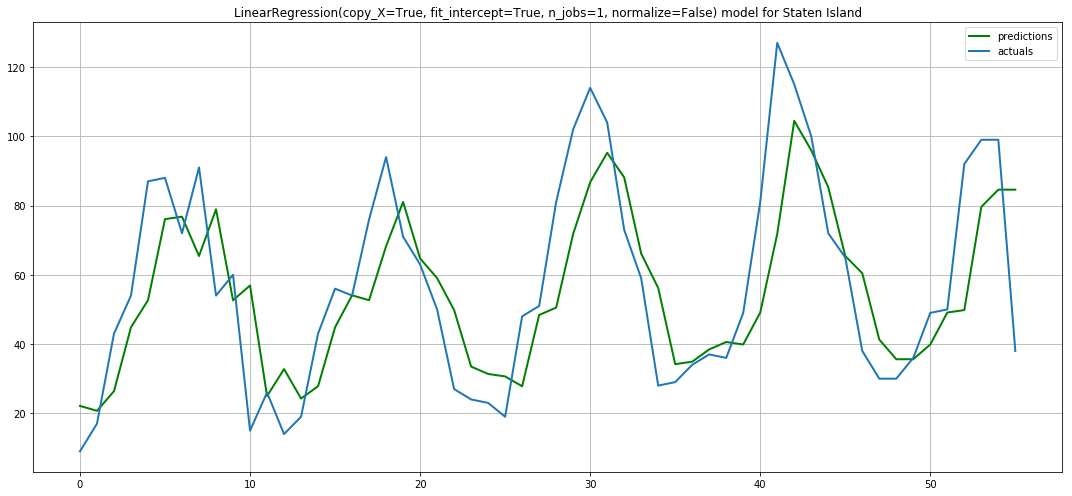

In [36]:
models, errors = modelResults(data=lag_data)
print(errors)
print("The average mean absolute error using the Linear Regression model was %f"%np.mean(errors))


So, the model did not perform any better. There would be more approved methods for evaluating whether or not to keep a feature such as analyzing p-values/significance or even automated feature extraction methods though those would hardly be necessary here due to our lack of variables. We will however employ ...

---

#### Regularization Methods

Regularization methods are a good way to handle feature selection. Ridge Regression will essentially seak to assign less important features with smaller coefficients and more important features with large coefficients. This is great when you are concerned about generalizability as it doesn't eliminate features deemed 'unimportant.' Lasso will eliminate 'unimportant' features by assigning a zero coefficient. This is great for automated feature selection as unnecessary features are completely removed. 

In [37]:
lag_data = data_lag(n_lags=3)
lag_data.head()

Borough       Date    t  Year    t-1    t-2
0   Bronx 2010-01-31  121  2010    NaN    NaN
1   Bronx 2010-02-28  110  2010  121.0    NaN
2   Bronx 2010-03-31  162  2010  110.0  121.0
3   Bronx 2010-04-30  180  2010  162.0  110.0
4   Bronx 2010-05-31  183  2010  180.0  162.0

[56.3976105881113, 87.32516388804386, 69.61964417041065, 33.82423207565872, 14.20092233278744]
The average mean absolute error using the Lasso Regularization Method was 52.273515


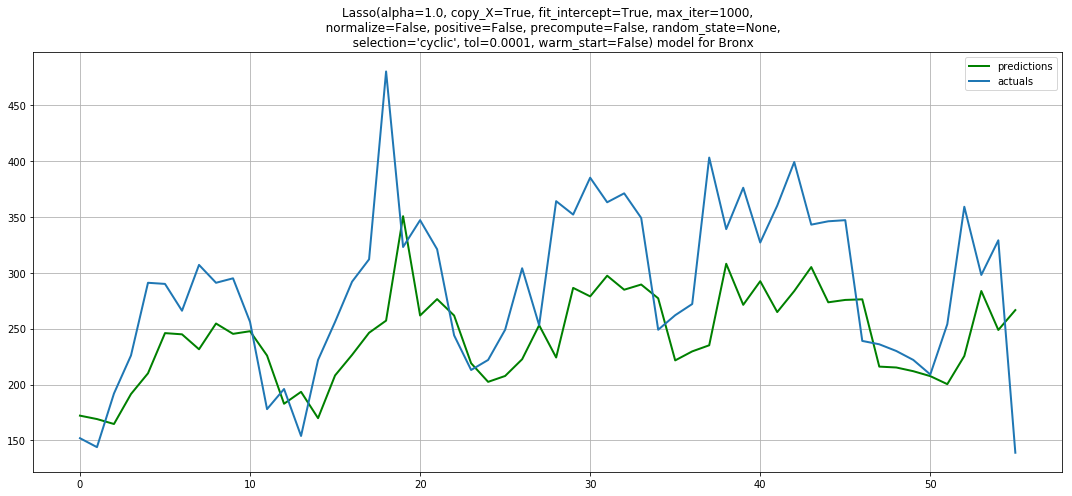

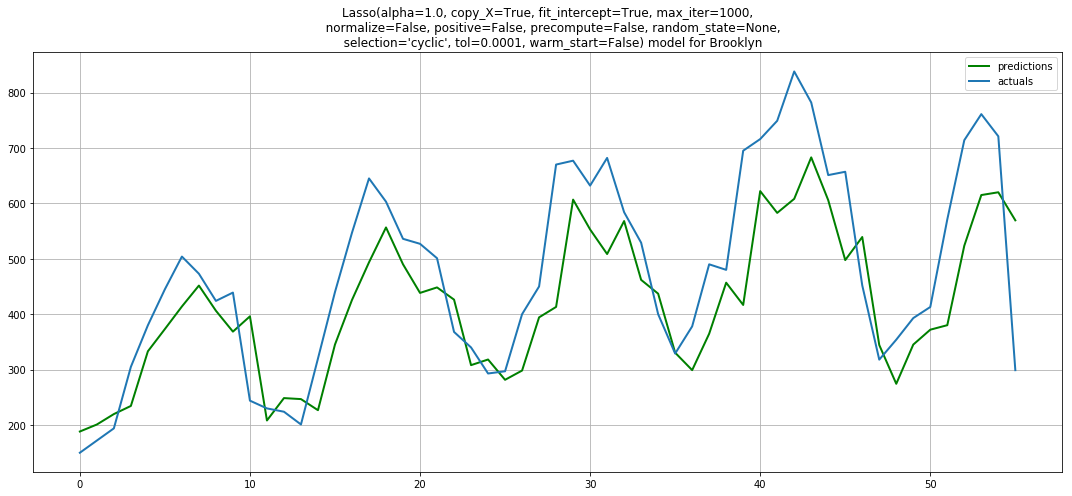

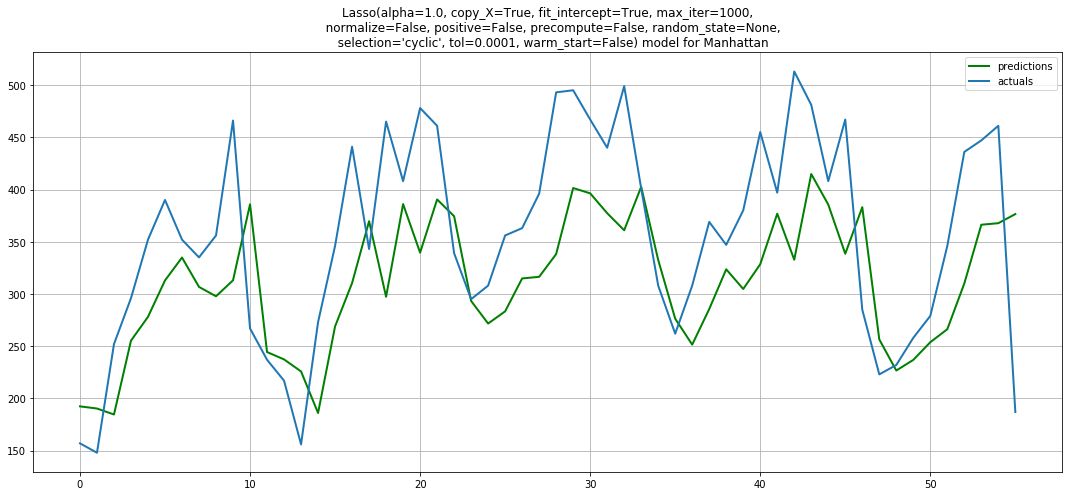

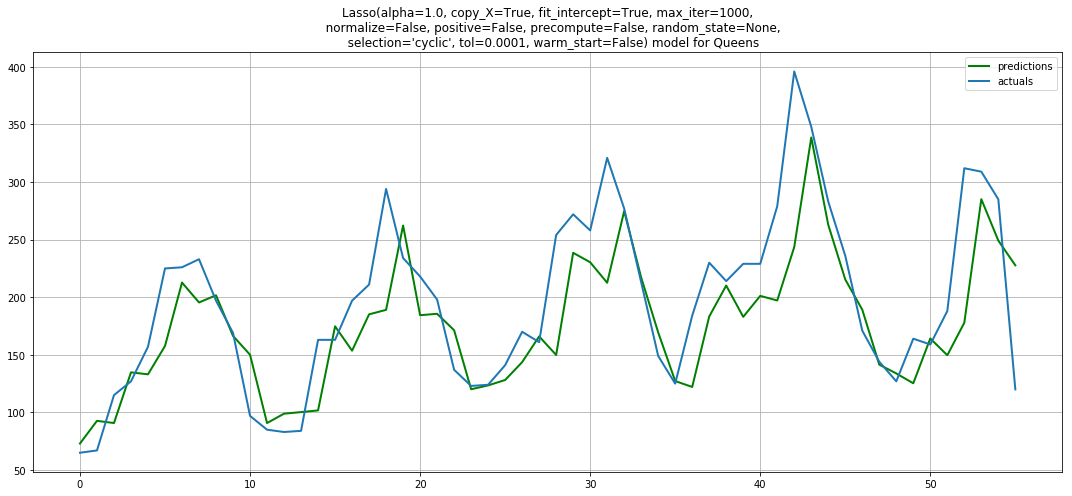

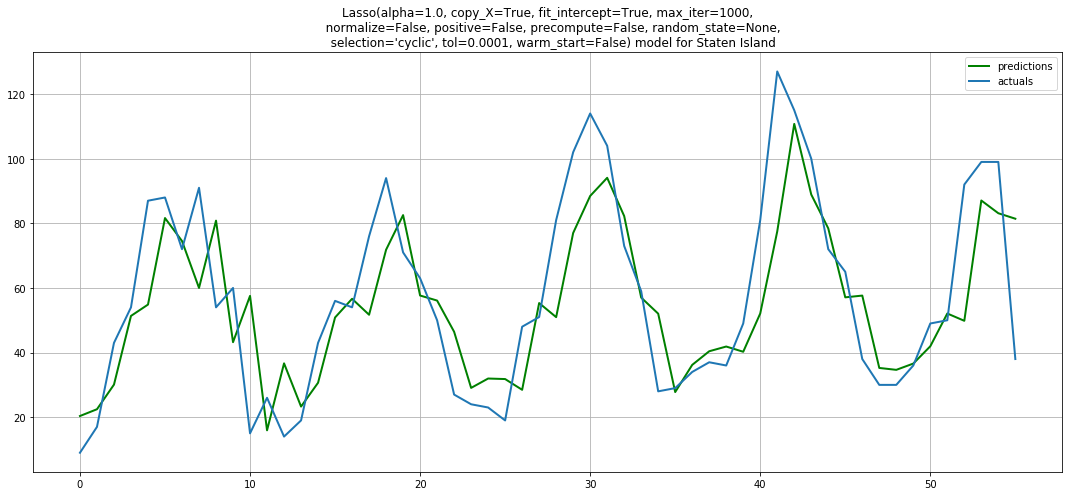

In [38]:
from sklearn.linear_model import Lasso, Ridge

models, errors = modelResults(model=Lasso(), data=lag_data)
print(errors)
print("The average mean absolute error using the Lasso Regularization Method was %f"%np.mean(errors))


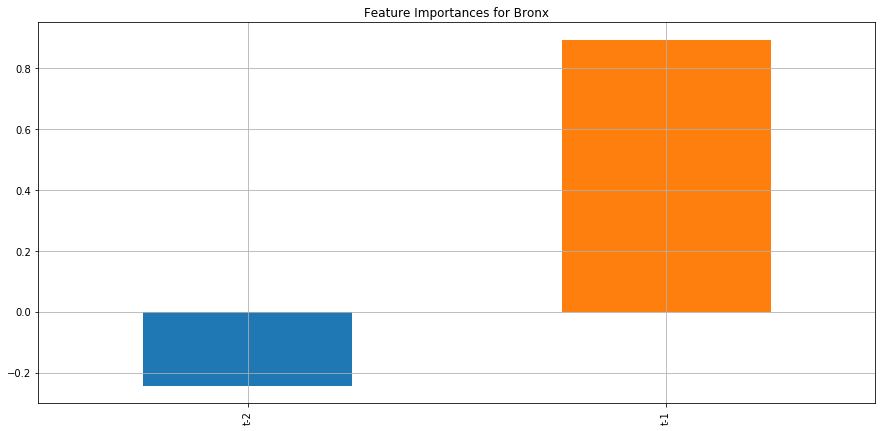

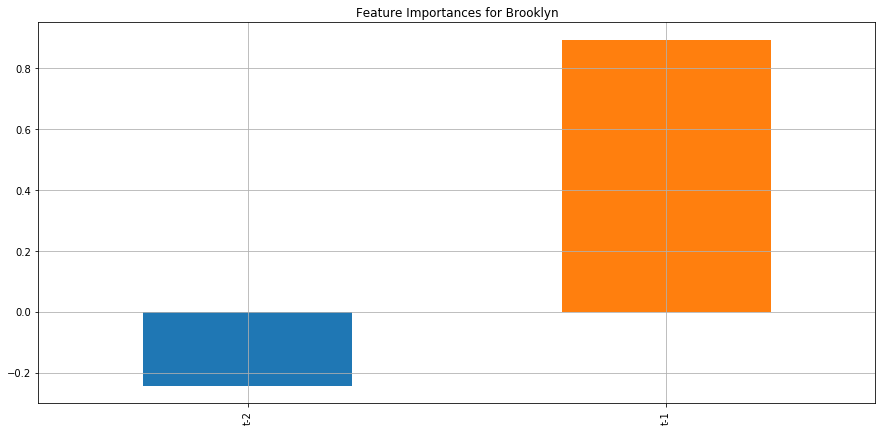

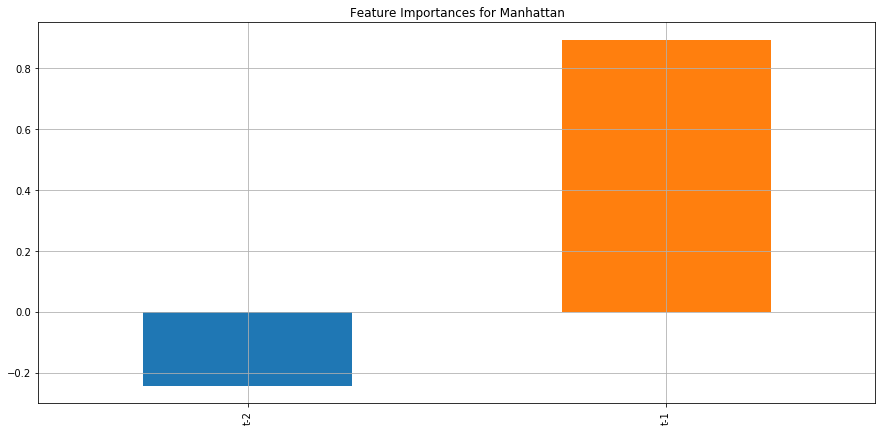

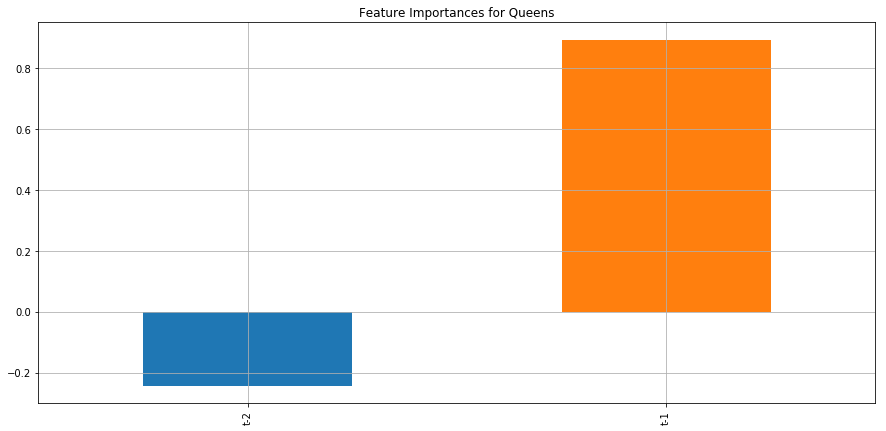

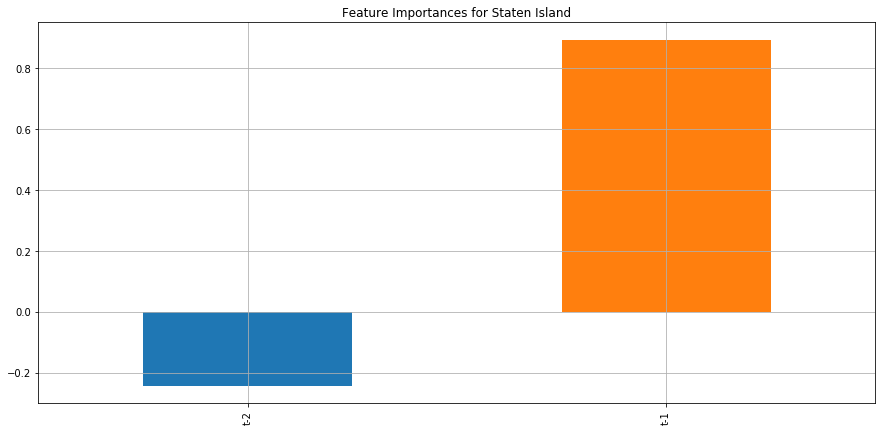

In [39]:
# we will provide the names of the features
names = [*(lag_data
           # drop unnecessary feats/target
           .drop(["Borough", "Date", "Year", "t"], axis=1)
           .columns)
        ]

plotFeatImp(names=names, models=models)

---

Now, Ridge

[56.390965942030626, 87.30980477335868, 69.60474550133496, 33.81252977155461, 14.184806017790283]
The average mean absolute error using the Ridge Regularization Method was 52.260570


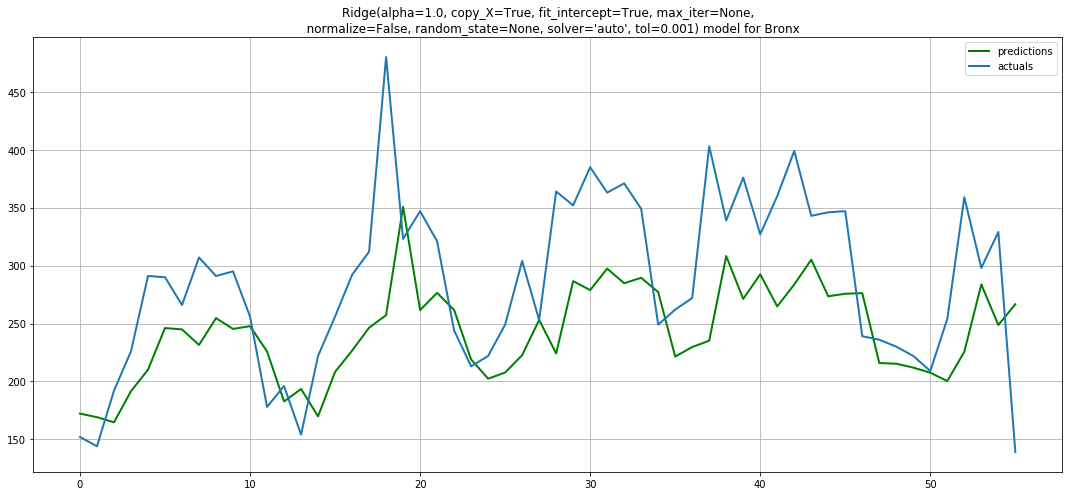

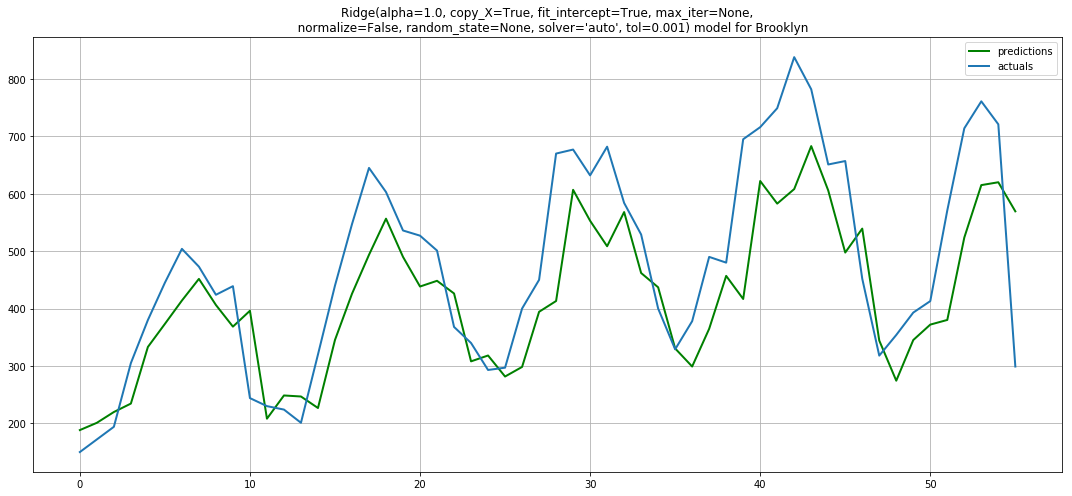

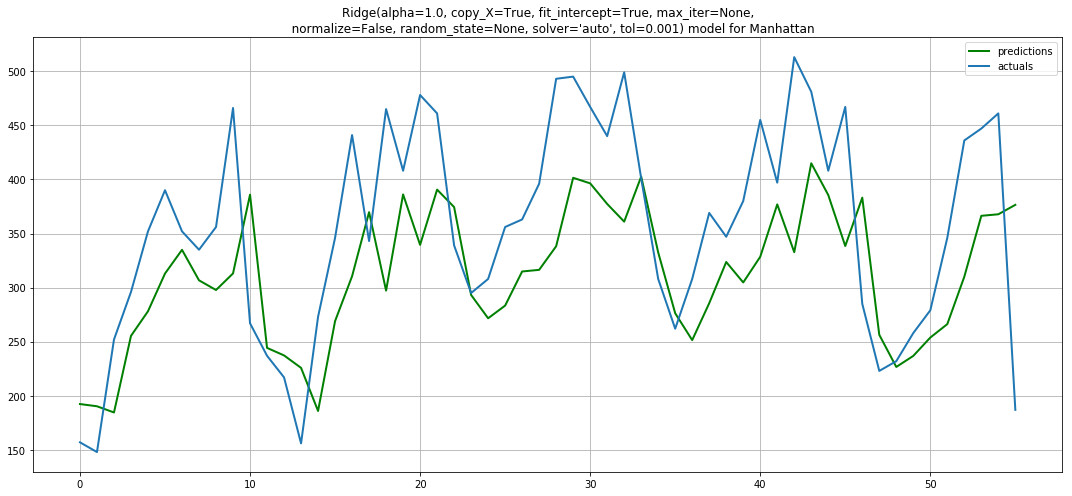

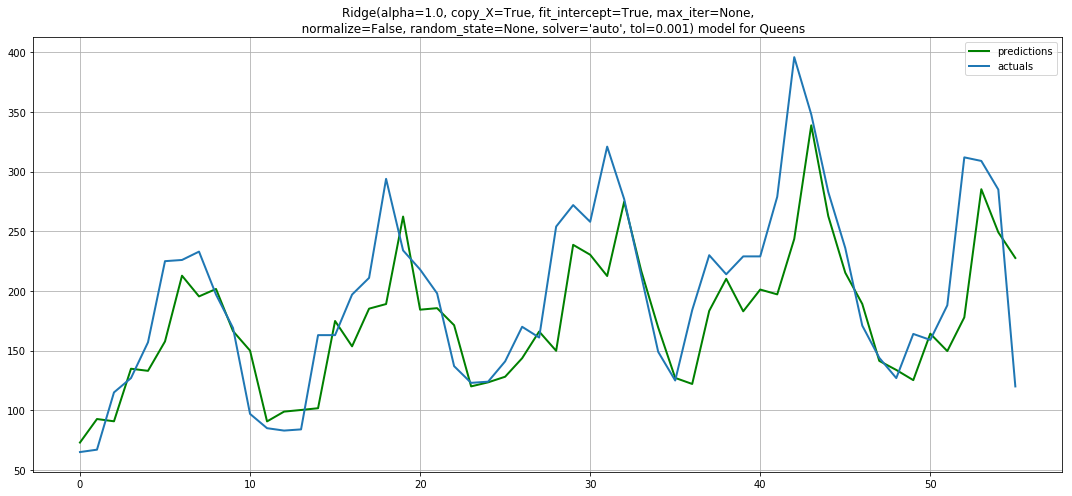

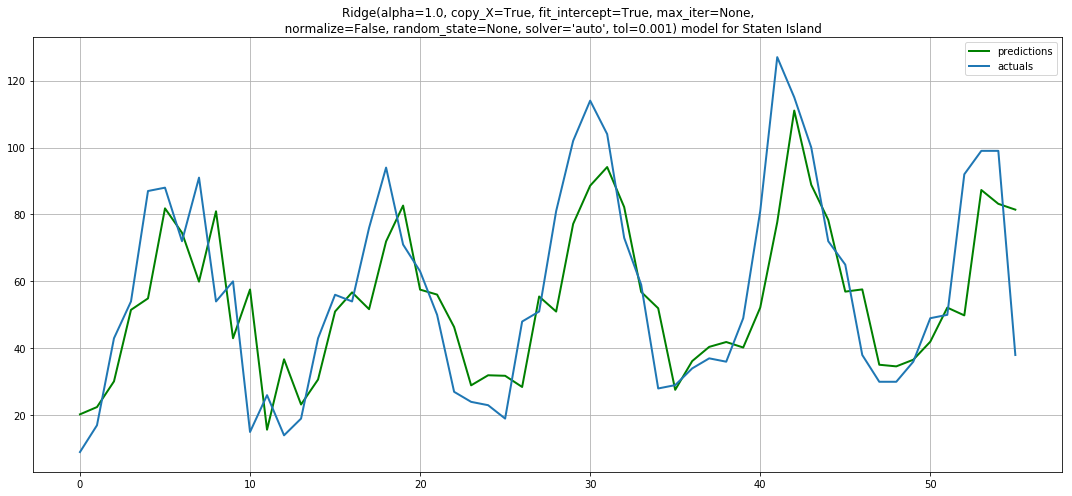

In [40]:
models, errors = modelResults(model=Ridge(), data=lag_data)
print(errors)
print("The average mean absolute error using the Ridge Regularization Method was %f"%np.mean(errors))


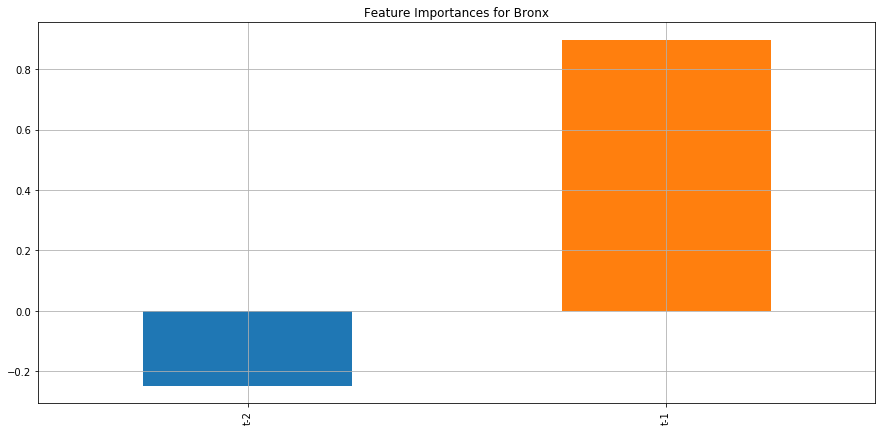

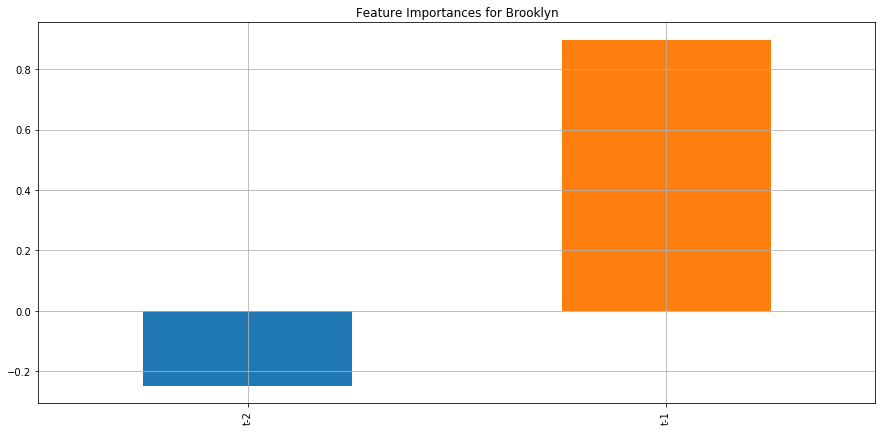

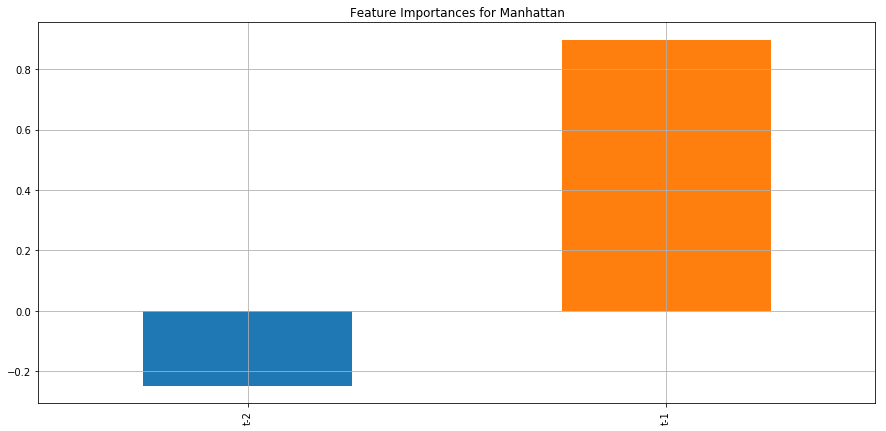

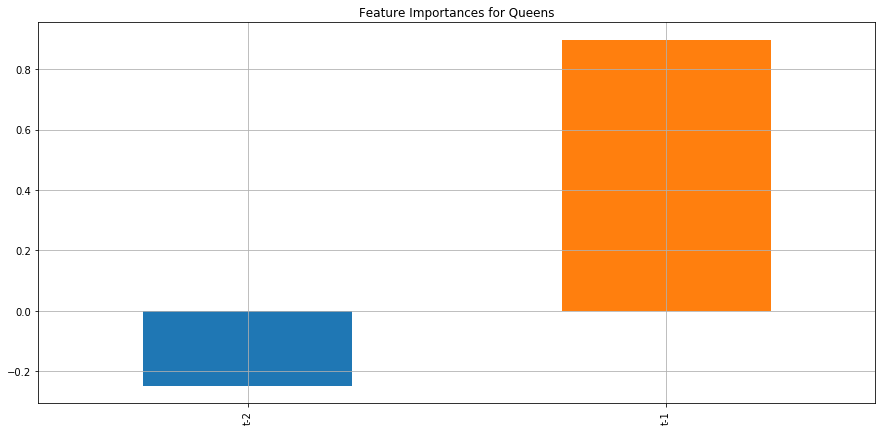

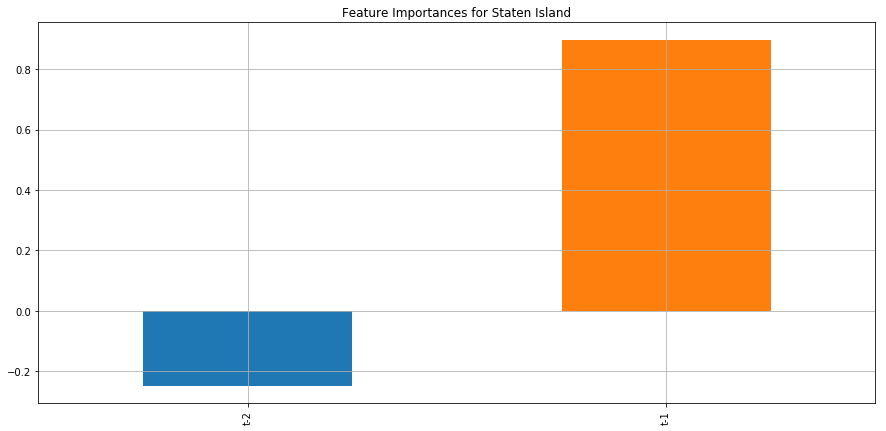

In [41]:
# we will provide the names of the features
names = [*(lag_data
           # drop unnecessary feats/target
           .drop(["Borough", "Date", "Year", "t"], axis=1)
           .columns)
        ]

plotFeatImp(names=names, models=models)

---

#### Parting Thoughts

So the Linear Regression model emerged as our best model. We could at this point take a further look at tuning the parameters to squeeze better results out, We could take a look at more complex models, we could reframe the regression problem into a classification problem, and so on. However, we do at this point have what appears to be a very serviceable model. 

It's possible that we may need to investigate for more features that describe the instance in a more meaningful way to our available models. Possibly, we could reframe the original dataset into a weekly analysis rather than a monthly analysis giving a larger decision space to train and test the model with. This could be accomplished simply by using the `set_index()` DataFrame method on the dataset and passing the column with the timestamps. Then, we would use the `.resample('W')` method on the dataframe. 

At this point, we now have our model, rather `models`, that we can save and apply to future data.
```python

import pickle

# create fun to save models
def save_models(obj, filename):
    
    with open(filename, "wb") as output:
        pickle.dump(obj,output, pickle.HIGHEST_PROTOCOL)
   
save_models(models, "lr_rats.pkl")
```

That wraps up this series. Thanks for reading!